# Анализ результатов парсинга сайта killpls.me

In [1]:
import re
import os
from os.path import join
import sys
sys.path.append('..')
import warnings
from tqdm import tqdm
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text
import umap
import hdbscan
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from modules.text_preprocessor import TextPreprocessor
from modules.text_summarizer import TextSummarizer
from modules.use_encoder import USEEncoder
from modules.visualizer import process_umap
from modules.cluster import calculate_number_clusters
from modules.killplsme.utilits import transform_data, plot_bar

warnings.filterwarnings('ignore') 
plt.style.use('seaborn-poster')

[nltk_data] Downloading package wordnet to /home/myonin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/myonin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
DIR_DATA = '../data/killplsme
DIR_MODELS = '../models'
DF = join(DIR_DATA, 'killplsme_20211004-194643.csv')
USE_MODEL = join(DIR_MODELS, 'use_model')

SEED=123

config = {
    'TextPreprocessor': {
        'mode_lower': False,
        'mode_del_numbers': False,
        'mode_norm': False,
        'mode_stemming': False,
        'mode_remove_stops': False,
        'mode_drop_long_words': True,
        'mode_drop_short_words': False,
        'min_len_word': 3,
        'max_len_word': 25,
        'text_column': 'text',
        'mode_del_eng': False,
        'mode_del_punctuation': False,
        'mode_sent_split': False
    },
    'USEEncoder': {
        'batch_size': 64,
        'text_column': 'clean_text',
    },
    'TextSummarizer': {
        'len_summary': 50,
        'text_column': 'text',
    },
}

## Cleaning data

In [3]:
df = pd.read_csv(DF, lineterminator='\n')

In [4]:
df.head()

,id,date,tags,likes,text
0,11,"16 марта 2009, 13:56",техника,-11312,\tВызвал сантехника прочистить раковину на кух...
1,10,"16 марта 2009, 13:56",отношения,26614,"\tЯ почти год встречаюсь с мужчиной, три месяц..."
2,9,"16 марта 2009, 13:56",отношения,13795,"\tЗадержался на пьянке по поводу праздника, по..."
3,8,"16 марта 2009, 13:55","работа , секс , друзья , отношения",126862,18+
4,7,"16 марта 2009, 13:55","семья , отношения",77501,"\tПока моя девушка пошла на часок к маме, зале..."


In [5]:
%%time
# Light cleaning text column
df = TextPreprocessor(config['TextPreprocessor']).transform(df)

CPU times: user 4.07 s, sys: 60.6 ms, total: 4.13 s
Wall time: 4.19 s


In [6]:
# Copy data for text analisis
df_text = df[['tags', 'text', 'clean_text']]

In [8]:
# Cleaning and preparing data for analisis
df = transform_data(df)

100%|██████████| 27351/27351 [05:47<00:00, 78.81it/s] 


Old: (27351, 6) New: (44911, 13)


In [9]:
df.head()

,id,date,tags,likes,text,clean_text,days,months,years,time,hours,minutes,day_week
0,11,2009-03-16 13:56:00,техника,-11312,NaN,Вызвал сантехника прочистить раковину на кухне...,16,3,2009,13:56,13,56,Monday
0,10,2009-03-16 13:56:00,отношения,26614,NaN,"Я почти год встречаюсь с мужчиной, три месяца ...",16,3,2009,13:56,13,56,Monday
0,9,2009-03-16 13:56:00,отношения,13795,NaN,"Задержался на пьянке по поводу праздника, по д...",16,3,2009,13:56,13,56,Monday
0,8,2009-03-16 13:55:00,работа,126862,NaN,18+,16,3,2009,13:55,13,55,Monday
1,8,2009-03-16 13:55:00,секс,126862,NaN,18+,16,3,2009,13:55,13,55,Monday


##  Meta Info Analysis

In [12]:
# Больше всего постов было в 2010-2011 гг
df[['id', 'years']].drop_duplicates()['years'].value_counts()

2010    2484
2011    2467
2013    2134
2016    2060
2019    2059
2015    2052
2017    2051
2012    2004
2018    1987
2020    1977
2009    1829
2014    1670
2021    1626
Name: years, dtype: int64

In [13]:
# Пик по активности на 2011-2013 гг
df[['id', 'years', 'likes']].drop_duplicates(subset=['id', 'years']).groupby('years')['likes'].sum()

years
2009     4701812
2010     8764440
2011    14032438
2012    17278407
2013    17257567
2014     7295220
2015     7688722
2016     6556345
2017     4241717
2018     3586457
2019     3516613
2020     2821886
2021     2161876
Name: likes, dtype: int64

In [14]:
# Май - самый депрессивный месяц. В январе-феврале меньше всего публикаций
df[['id', 'months']].drop_duplicates()['months'].value_counts()

5     2412
8     2377
9     2370
6     2303
4     2271
7     2236
3     2233
10    2189
12    2131
11    2130
1     1942
2     1806
Name: months, dtype: int64

In [15]:
# Creating timeserias by years and months
df_by_years = df[['id', 'date']]
df_by_years = df_by_years.drop_duplicates()
df_by_years['updates'] = 1

df_by_years_likes = df[['id', 'date', 'likes']]
df_by_years_likes = df_by_years_likes.drop_duplicates()
df_by_years_likes.loc[df_by_years_likes['likes'] < 0,'likes'] = \
df_by_years_likes.loc[df_by_years_likes['likes'] < 0,'likes']*(-1)

df_by_months = df[['id', 'date']]
df_by_months = df_by_months.drop_duplicates()
df_by_months['updates'] = 1

df_by_years = df_by_years[['updates', 'date']].resample('Y', convention='end', label='left', on='date').sum()
df_by_years_likes = df_by_years_likes[['likes', 'date']].resample('Y', convention='end', label='left', on='date').sum()
df_by_months = df_by_months[['updates', 'date']].resample('M', convention='end', label='left', on='date').sum()

decomp_months = sm.tsa.seasonal_decompose(df_by_months.updates)

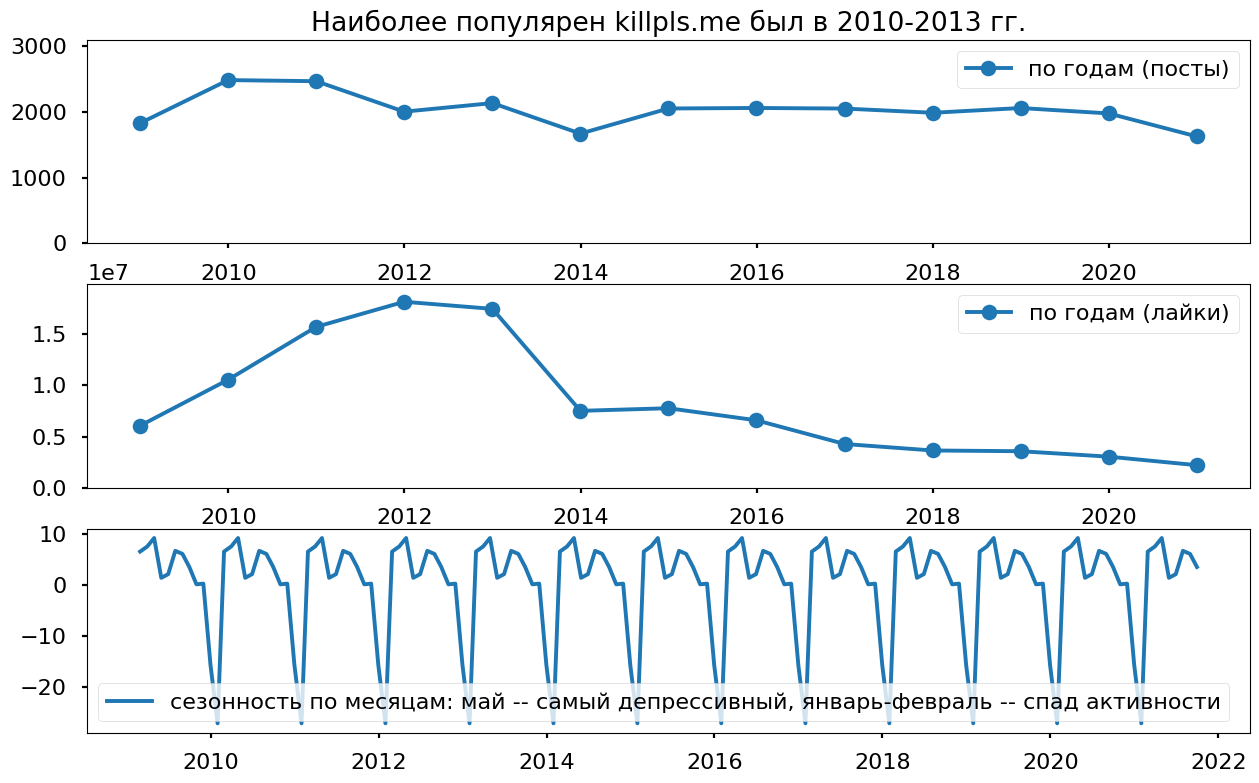

In [21]:
plt.figure(figsize=[15, 9])
plt.subplot(311)
plt.title('Наиболее популярен killpls.me был в 2010-2013 гг.')
plt.plot(df_by_years.updates, '-o', label='по годам (посты)')
plt.ylim([0,3100])
plt.legend()
plt.subplot(312)
plt.plot(df_by_years_likes.likes, '-o', label='по годам (лайки)')
plt.ylim([0,19822443])
plt.legend()
plt.subplot(313)
plt.plot(decomp_months.seasonal, '-', 
         label='сезонность по месяцам: май -- самый депрессивный, январь-февраль -- спад активности')
plt.legend()
plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44911 entries, 0 to 1
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          44911 non-null  object        
 1   date        44911 non-null  datetime64[ns]
 2   tags        44911 non-null  object        
 3   likes       44911 non-null  object        
 4   text        0 non-null      object        
 5   clean_text  44911 non-null  object        
 6   days        44911 non-null  object        
 7   months      44911 non-null  object        
 8   years       44911 non-null  object        
 9   time        44911 non-null  object        
 10  hours       44911 non-null  object        
 11  minutes     44911 non-null  object        
 12  day_week    44911 non-null  object        
dtypes: datetime64[ns](1), object(12)
memory usage: 4.8+ MB


In [28]:
df['likes'] = df['likes'].astype('int')
df_count = (df[df.years == '2021'].tags.value_counts()/df[df.years == '2021'].tags.value_counts().sum()).sort_values()
df_tags_likes = df[df.years == '2021'].groupby('tags')['likes'].median().sort_values()

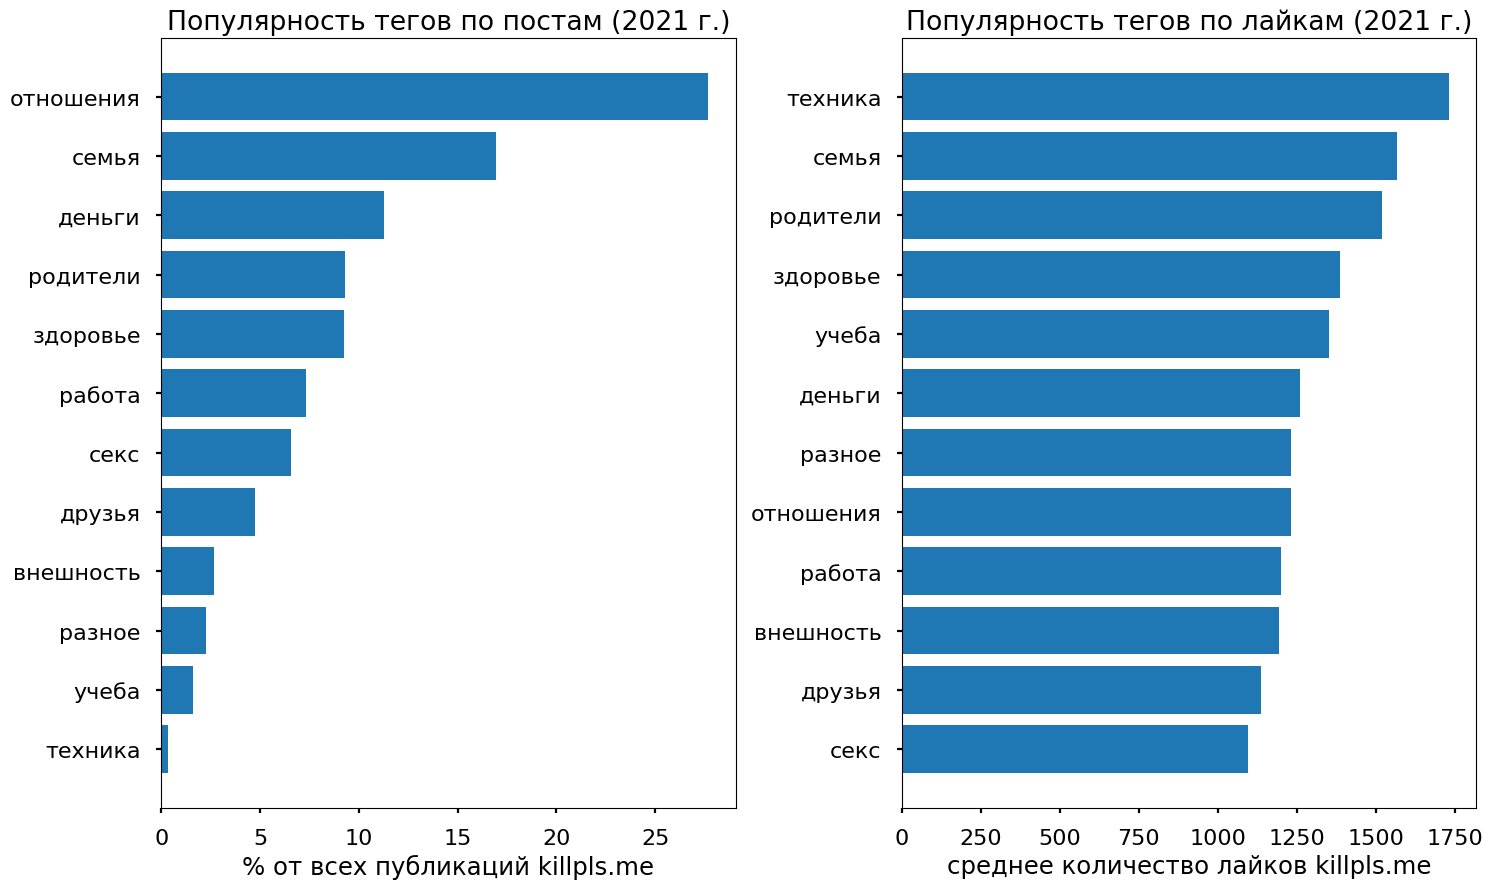

In [31]:
plt.figure(figsize=(15,9))
plt.subplot(121)
plt.title('Популярность тегов по постам (2021 г.)')
plt.barh(df_count.index, round(df_count*100, 2))
plt.xlabel('% от всех публикаций killpls.me')
plt.tight_layout()
plt.subplot(122)
plt.title('Популярность тегов по лайкам (2021 г.)')
plt.barh(df_tags_likes.index, df_tags_likes.values)
plt.xlabel('среднее количество лайков killpls.me')
plt.tight_layout()
plt.show() 

In [32]:
df_tags_likes_years = df.groupby(['years','tags'])['likes'].median().sort_values()
df_tags_likes_years = df_tags_likes_years.reset_index()
df_tags_likes_years = df_tags_likes_years.sort_values('years')
df_tags_likes_years.years = df_tags_likes_years.years.astype('int')

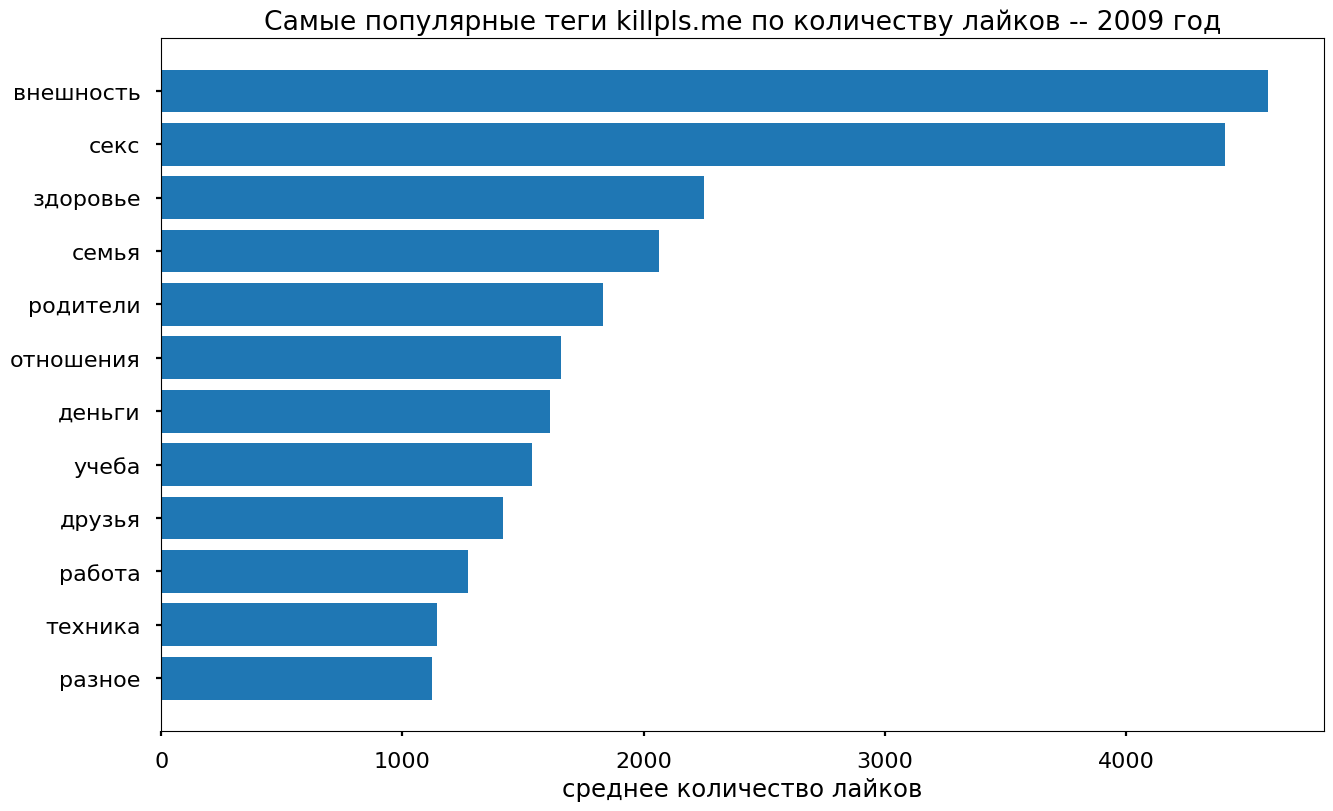

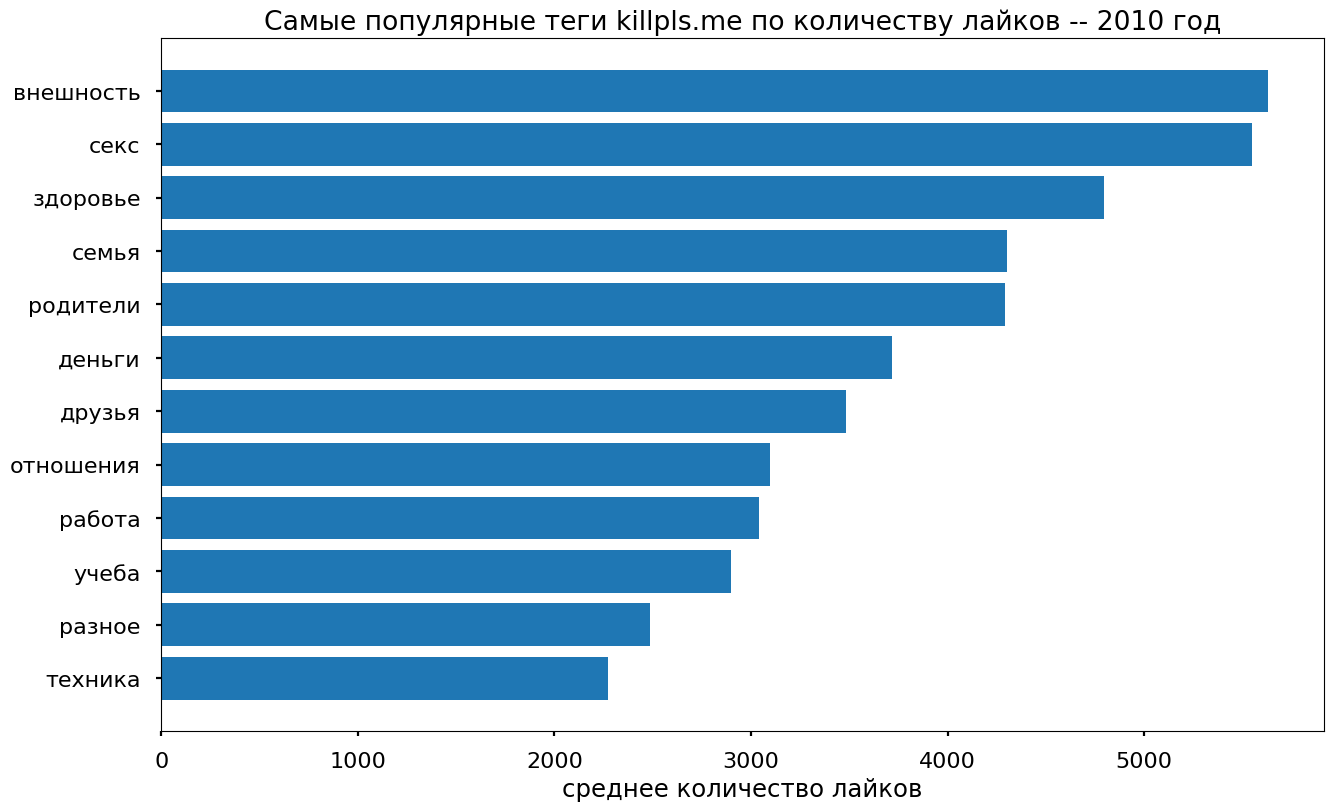

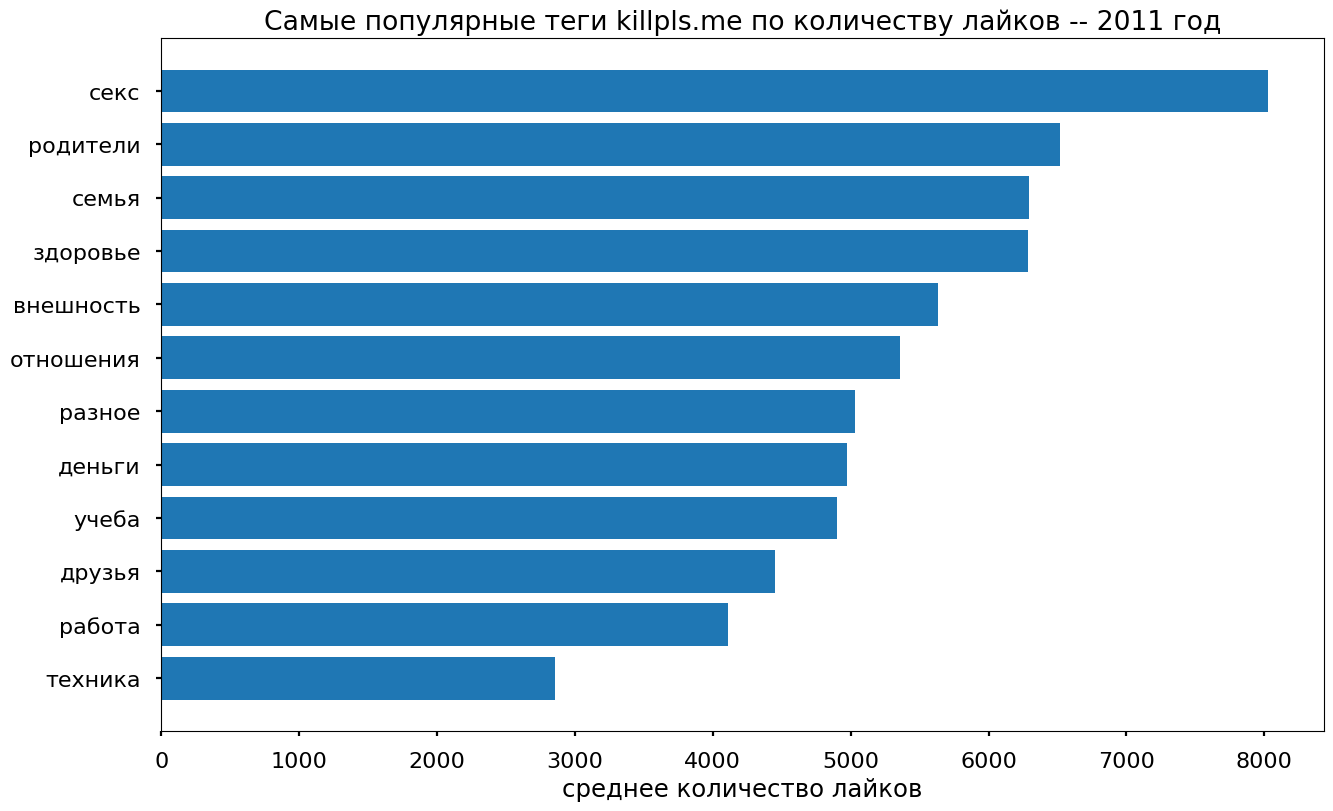

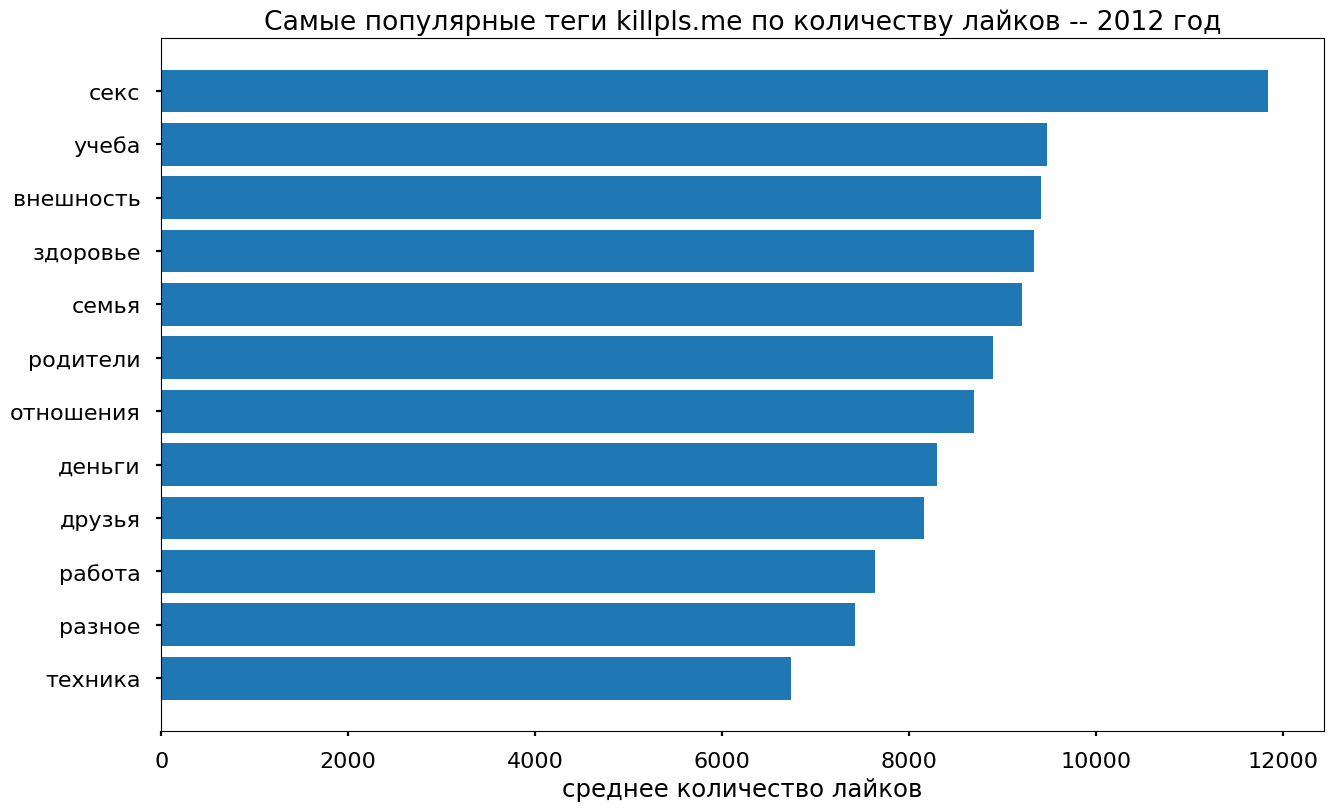

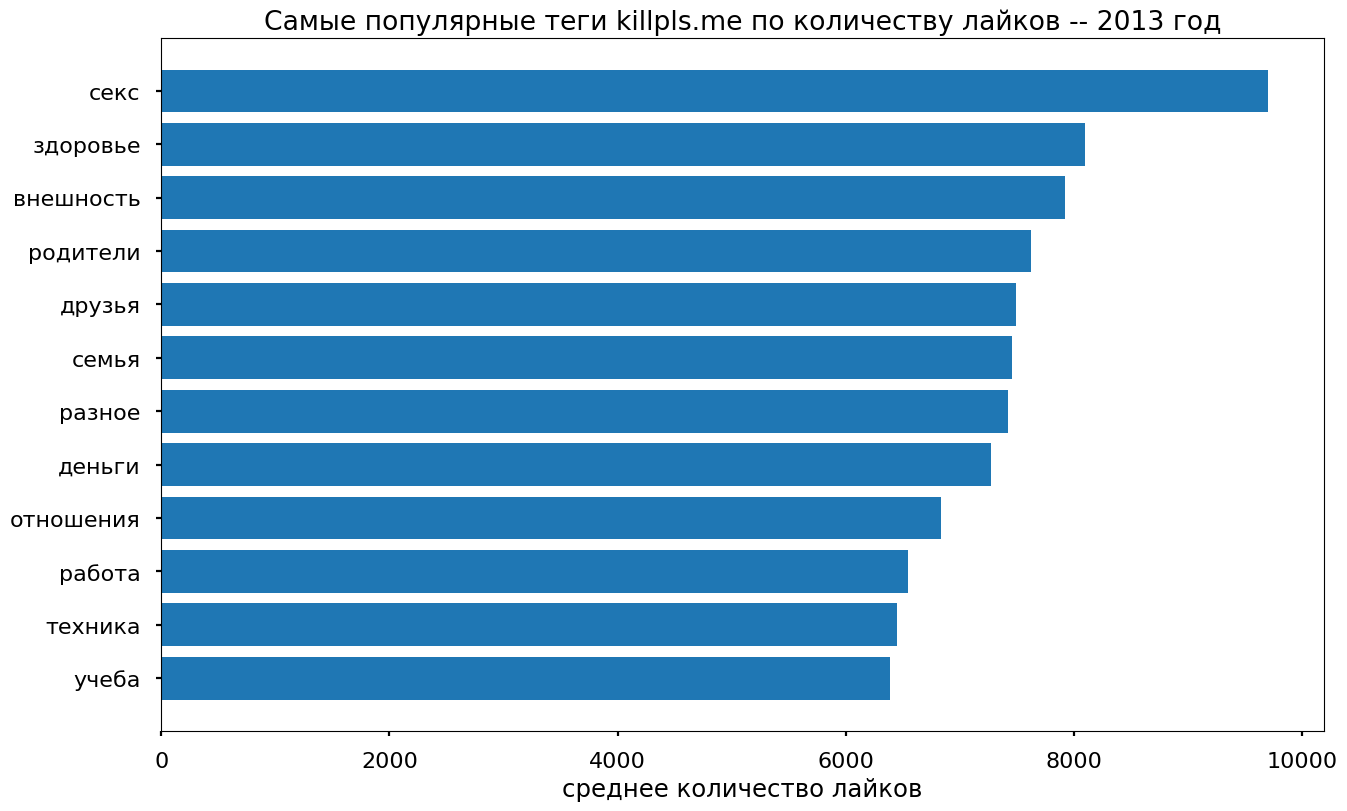

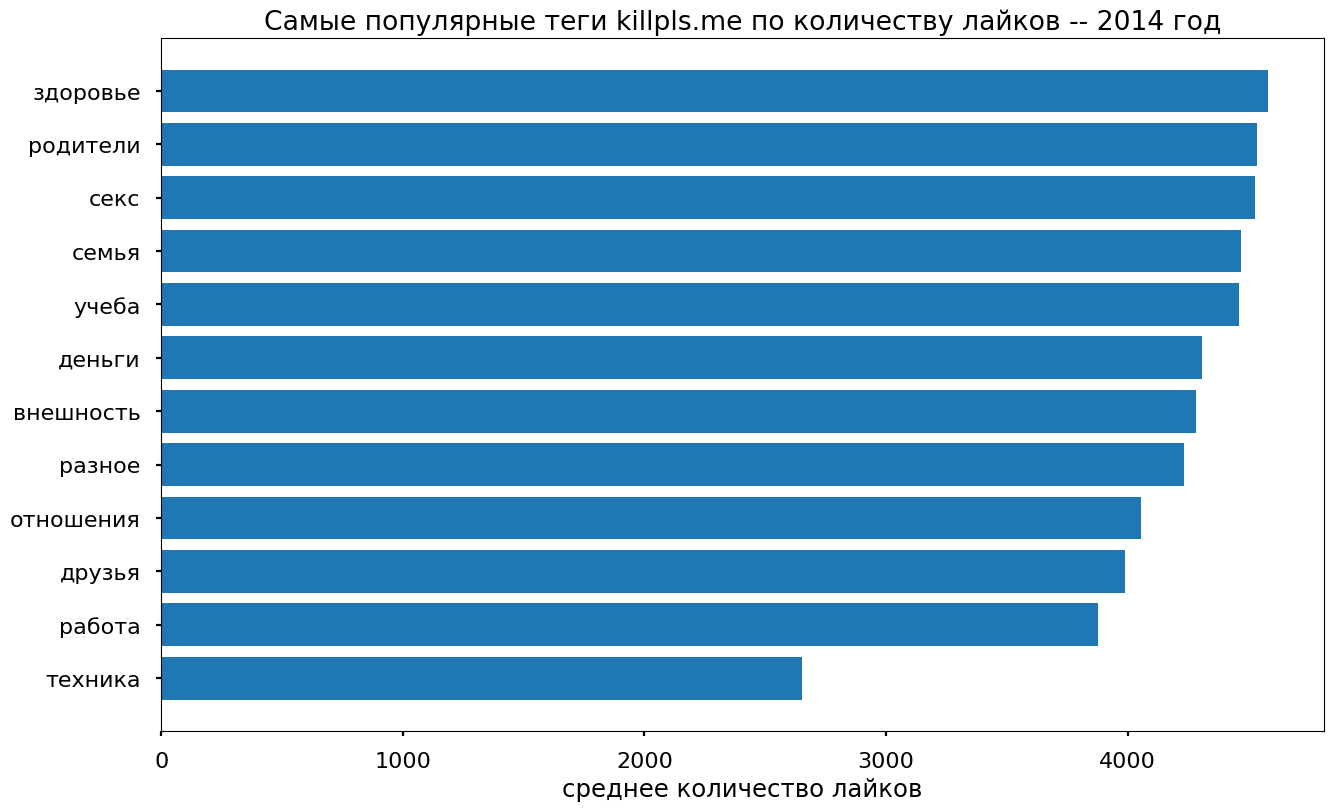

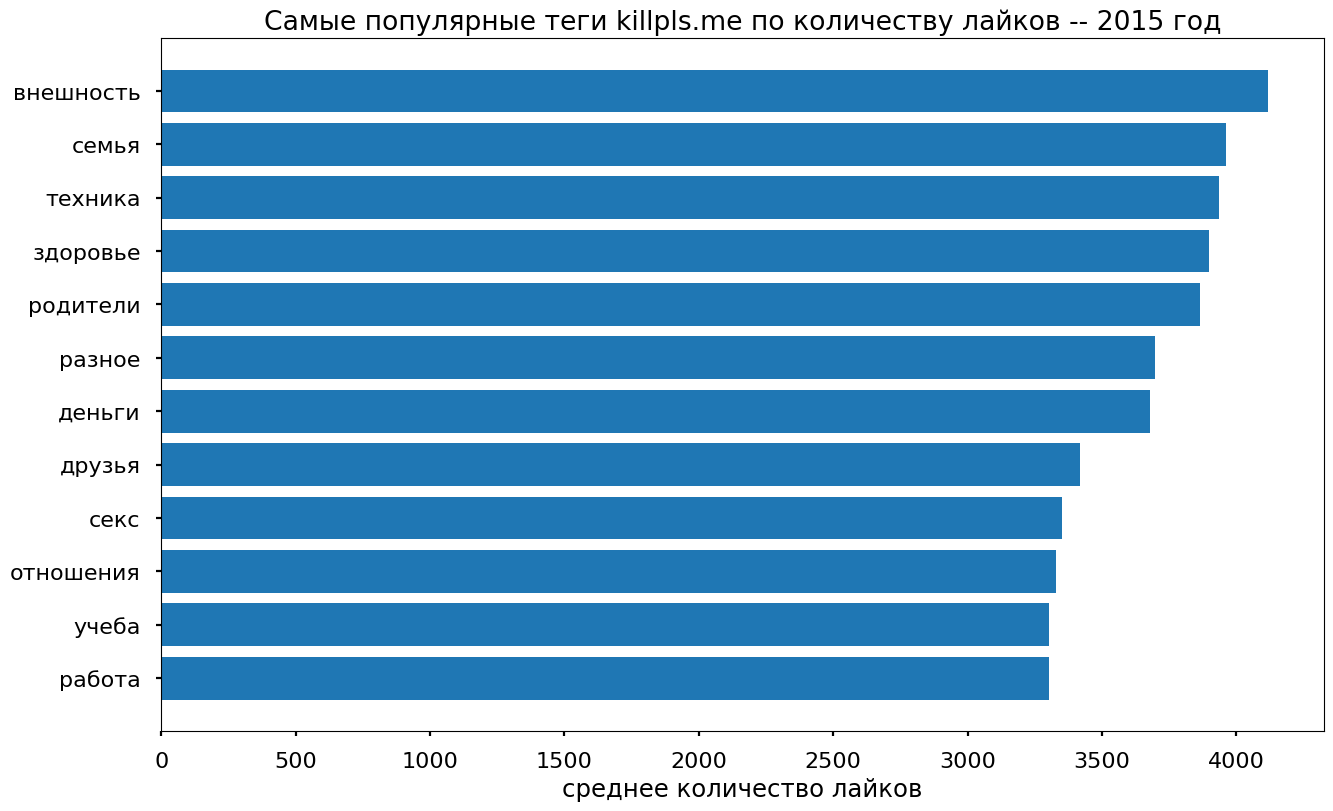

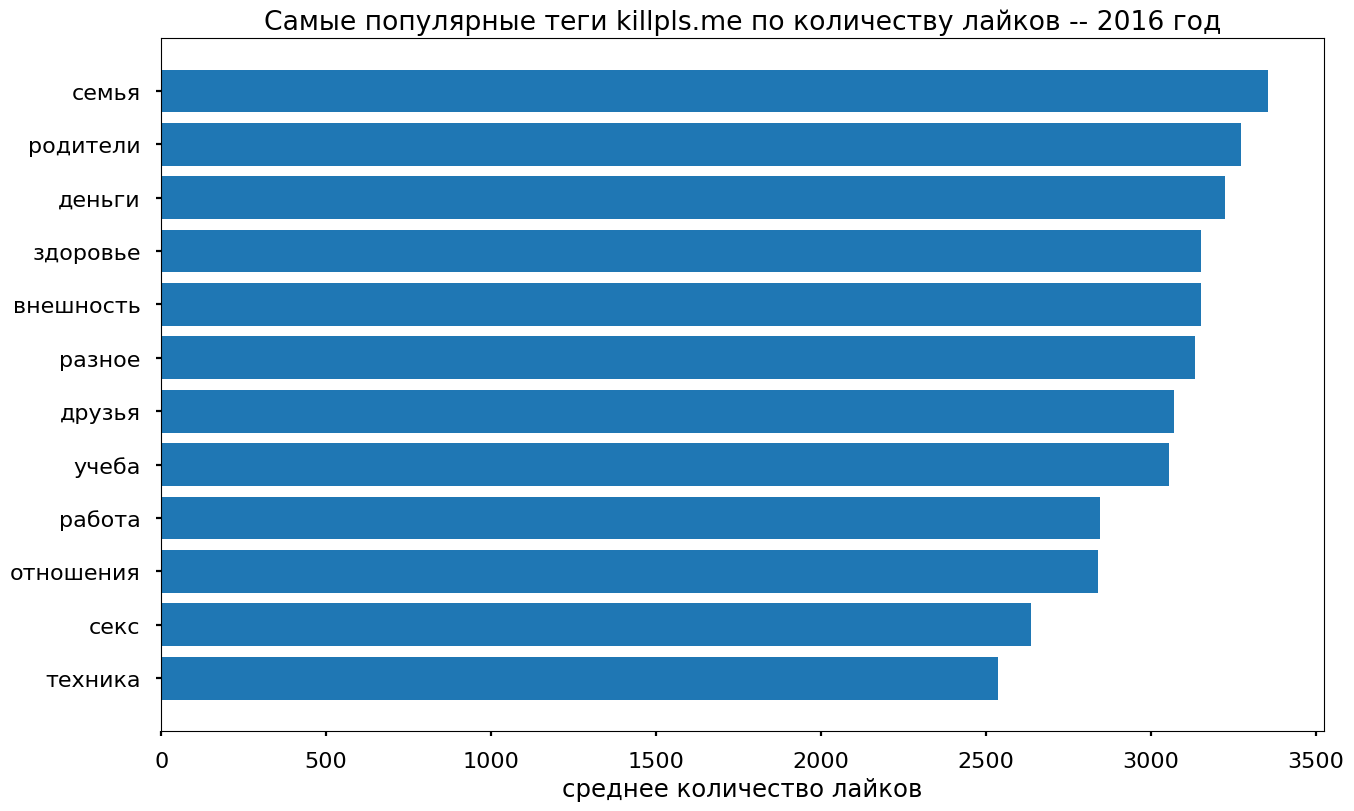

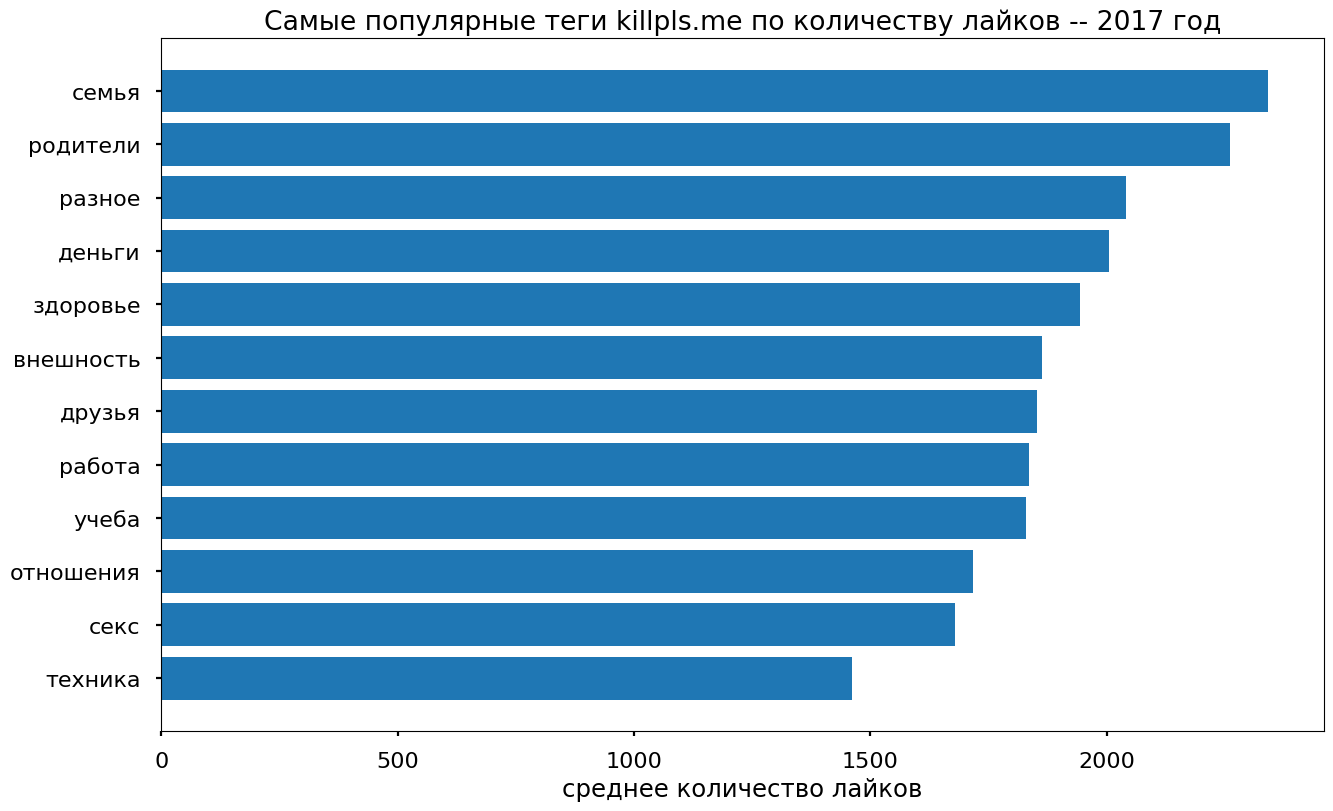

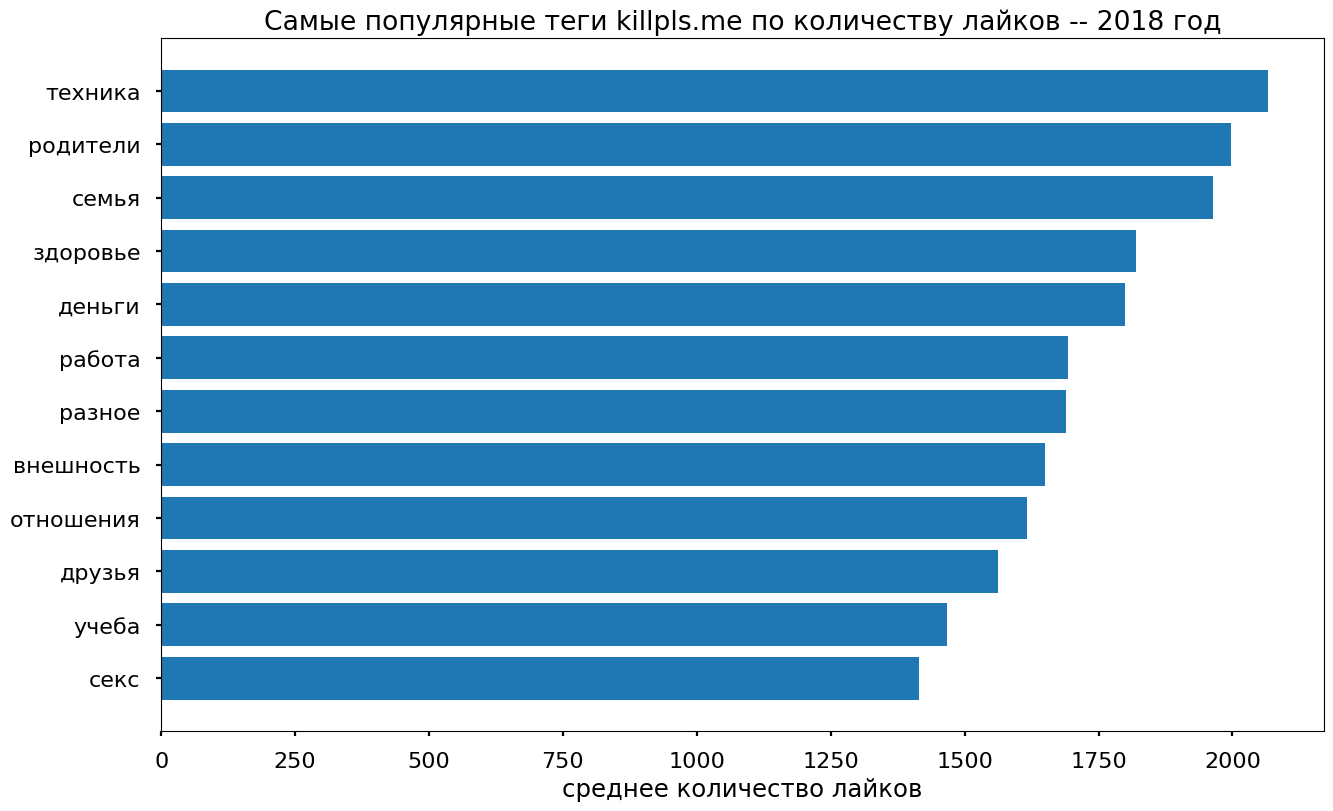

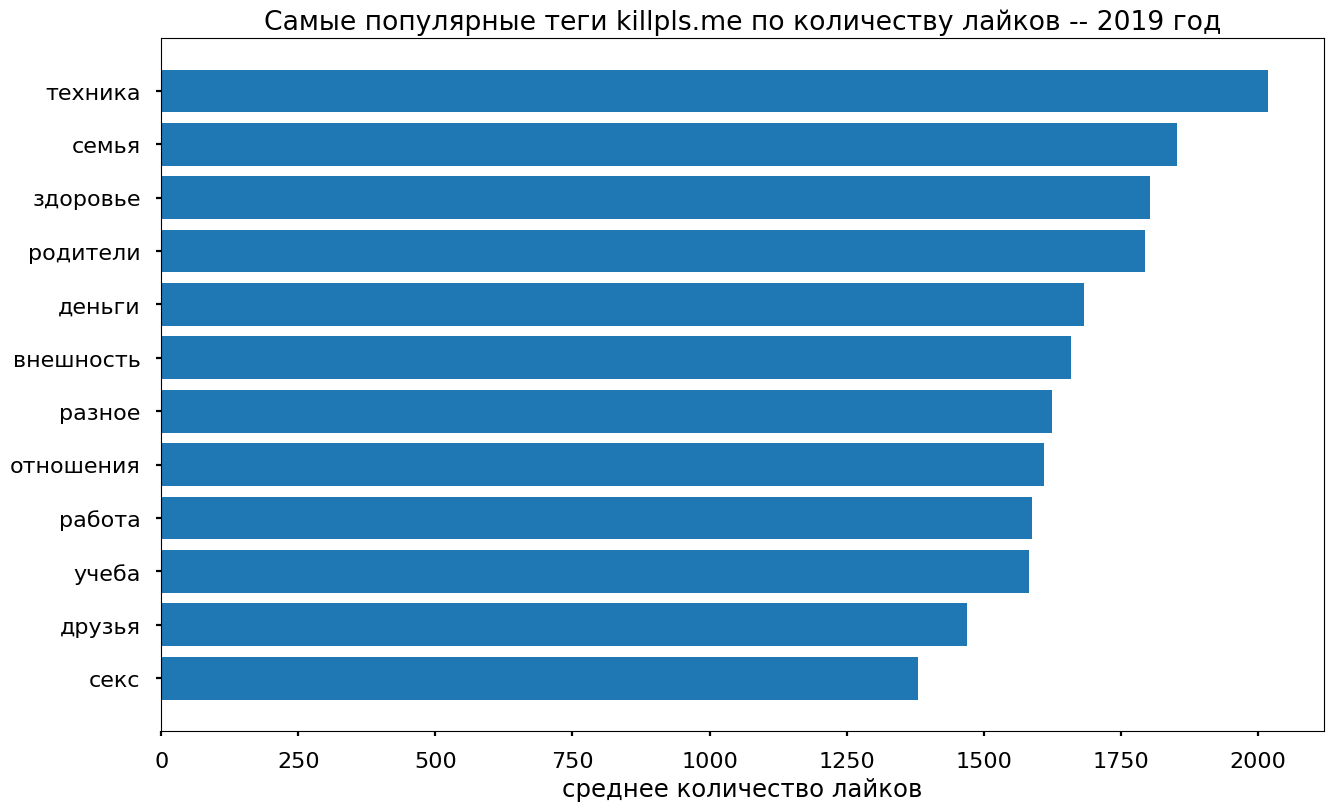

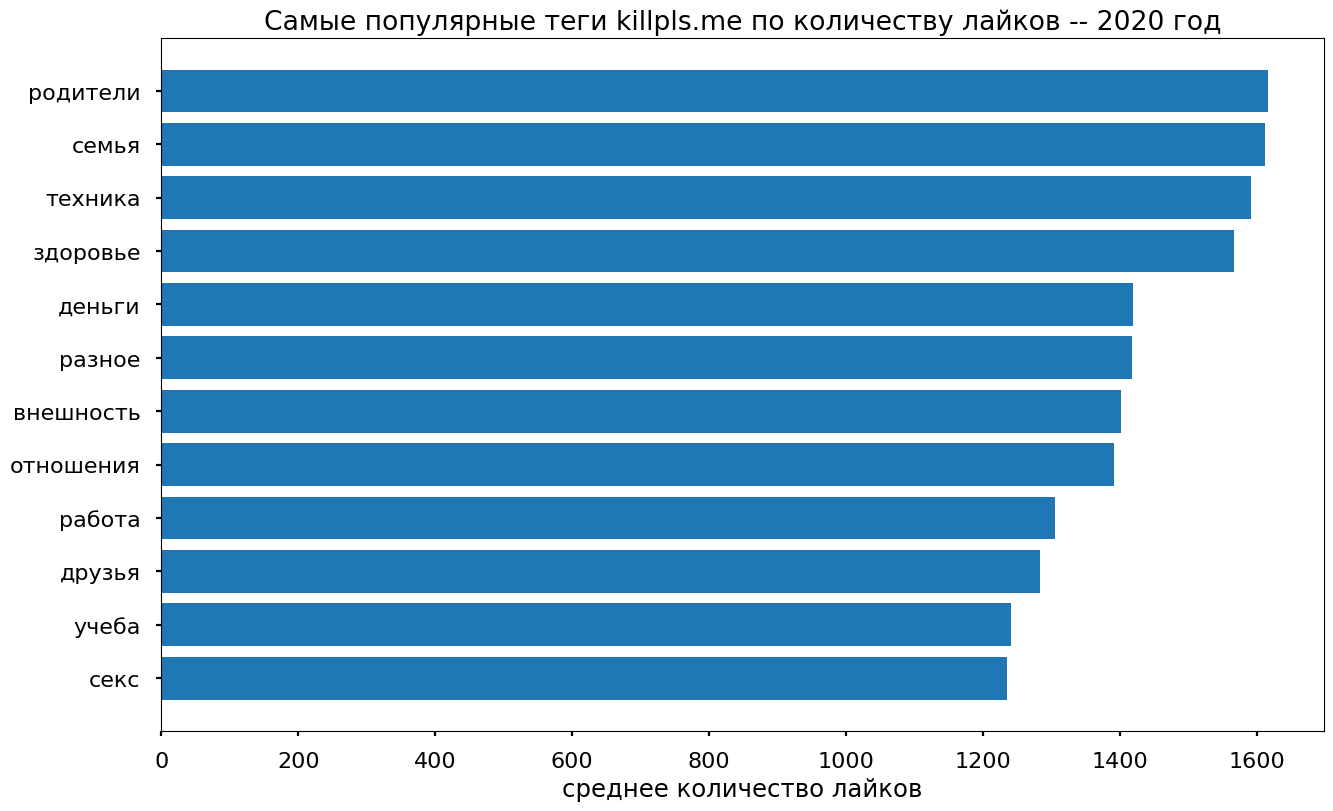

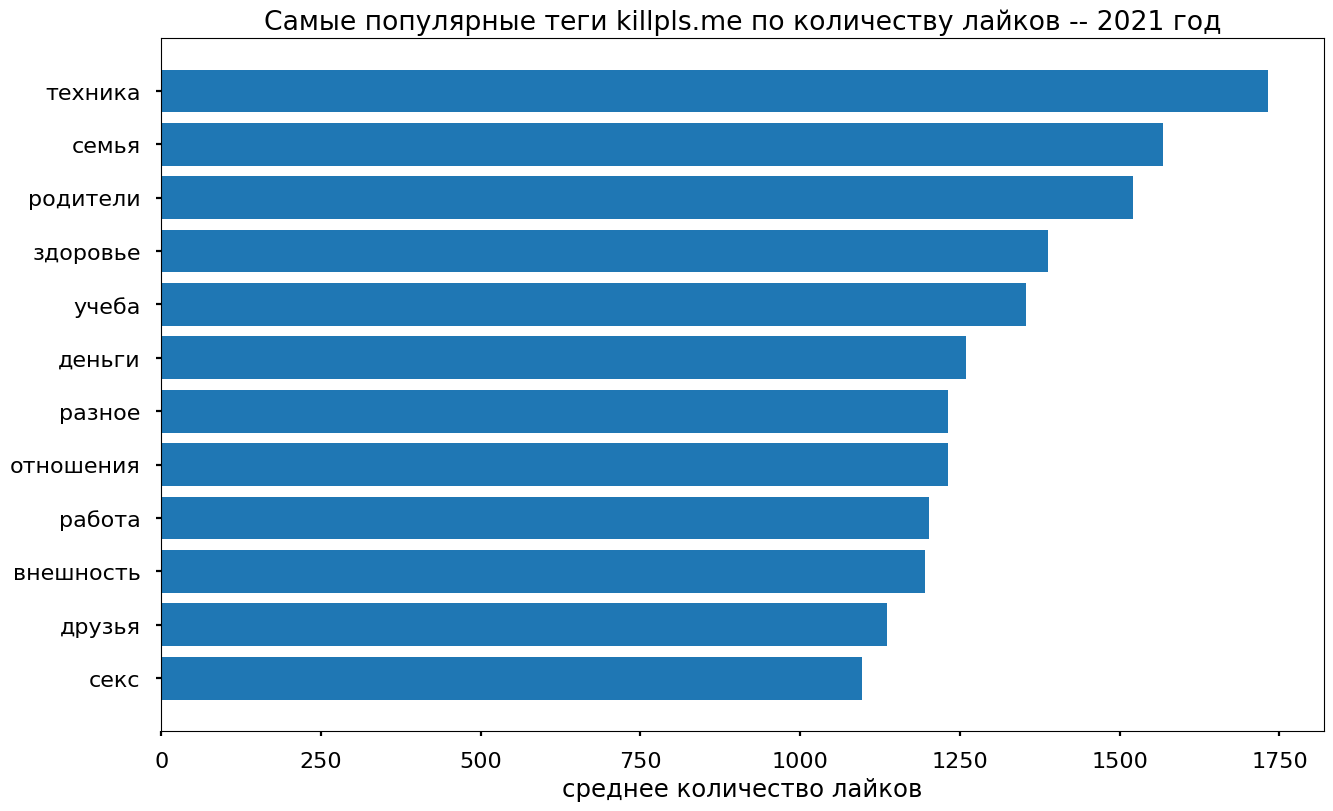

In [33]:
for year in df_tags_likes_years.years.unique():
    plot_bar(
        title='Самые популярные теги killpls.me по количеству лайков -- {} год'.format(year), 
        xlabel='среднее количество лайков', 
        x=df_tags_likes_years[df_tags_likes_years.years == year].sort_values('likes').tags, 
        y=df_tags_likes_years[df_tags_likes_years.years == year].sort_values('likes').likes
    )

In [34]:
df_tags_count_years = df.groupby(['years'])['tags'].value_counts().reset_index(0)
df_tags_count_years.columns = ['years', 'count']
df_tags_count_years = df_tags_count_years.reset_index()

df_tags_count_years['sum_by_years'] = 0
for year in df_tags_count_years.years.unique():
    indx = df_tags_count_years.years == year
    df_tags_count_years.loc[indx,'sum_by_years'] = df_tags_count_years.loc[indx,'count'].sum()

df_tags_count_years['rate'] = df_tags_count_years['count']/df_tags_count_years.sum_by_years

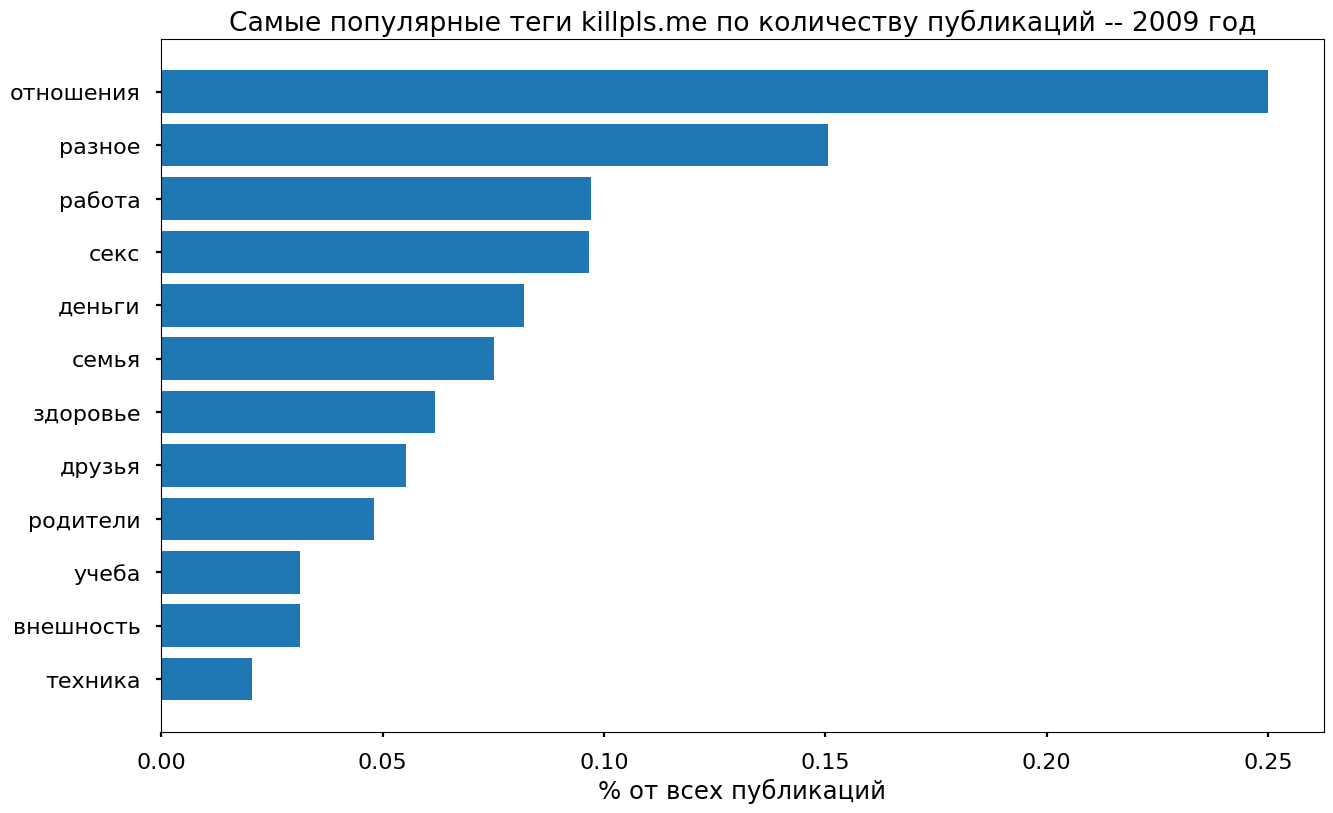

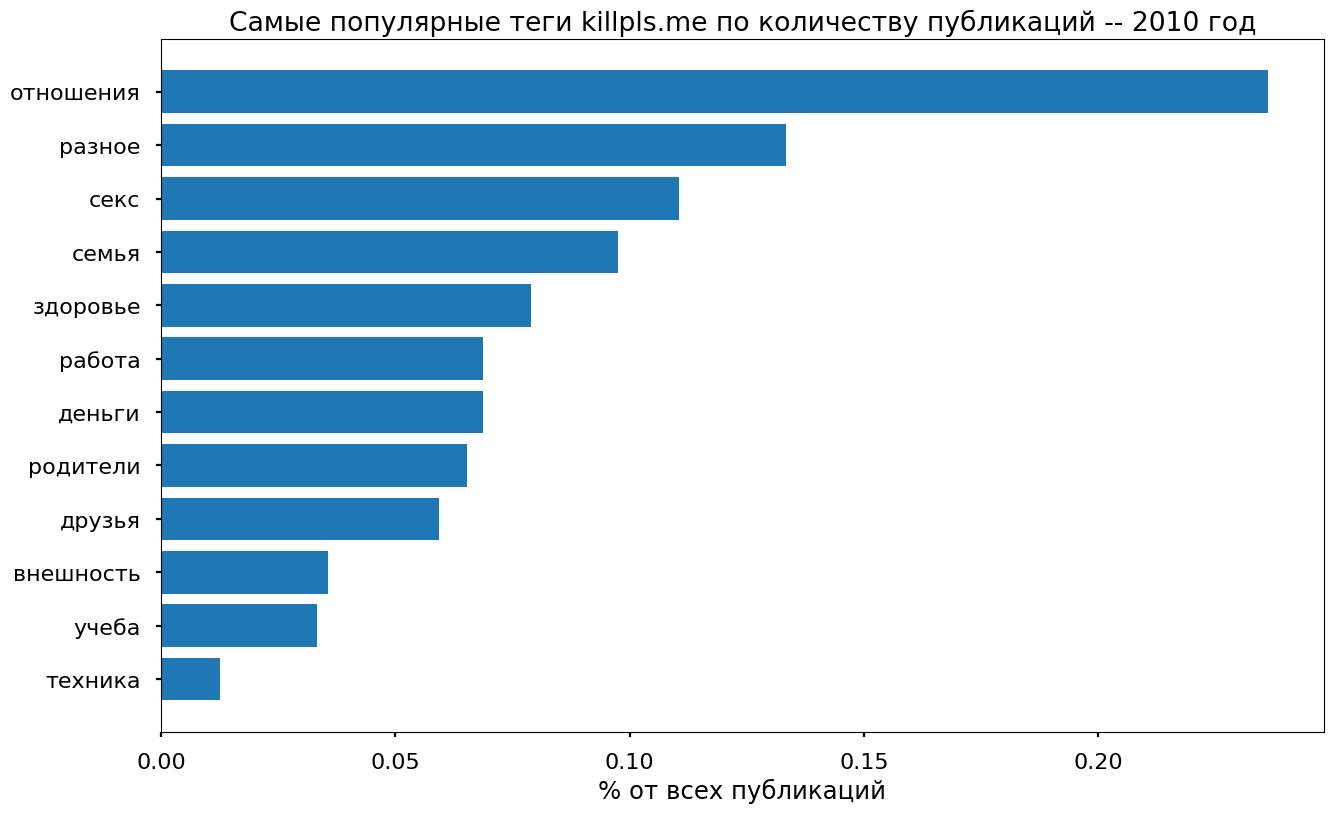

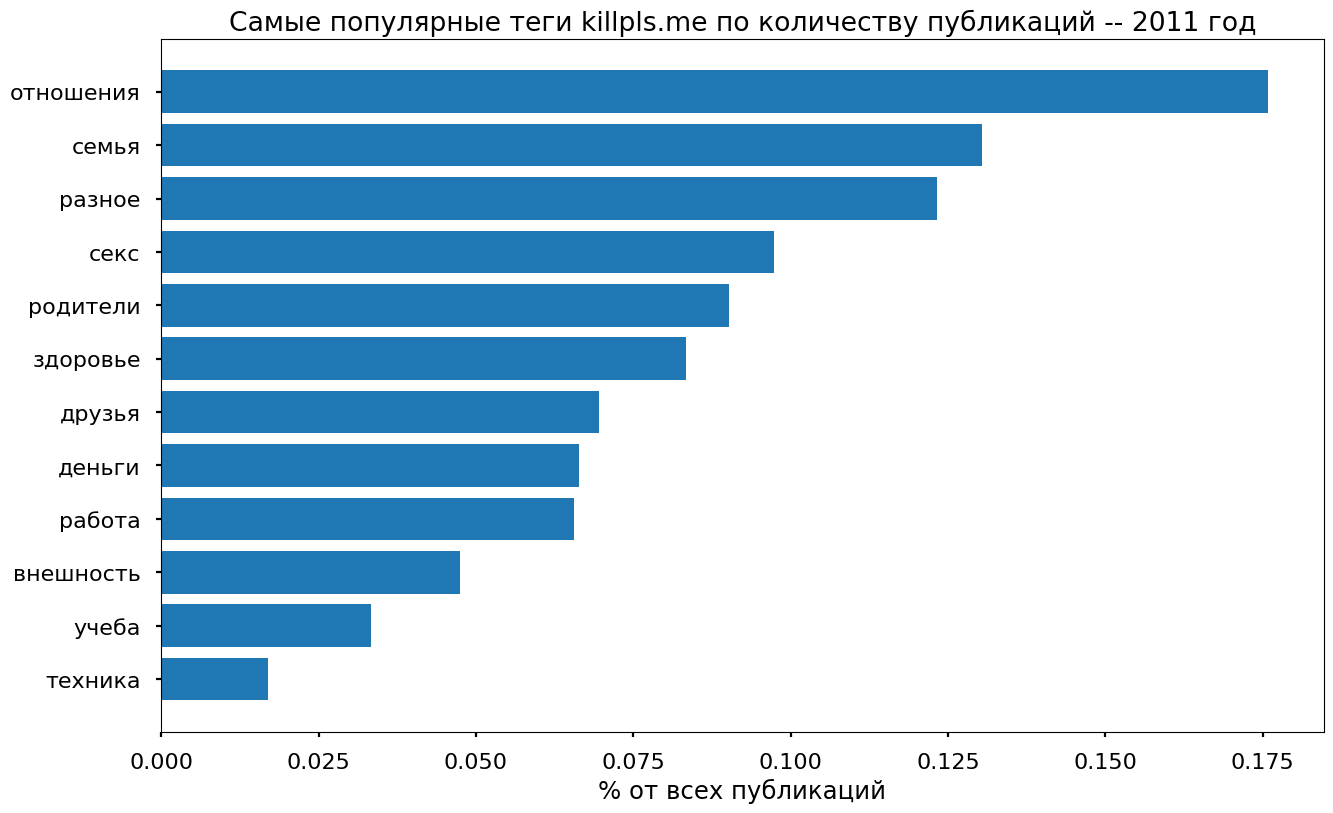

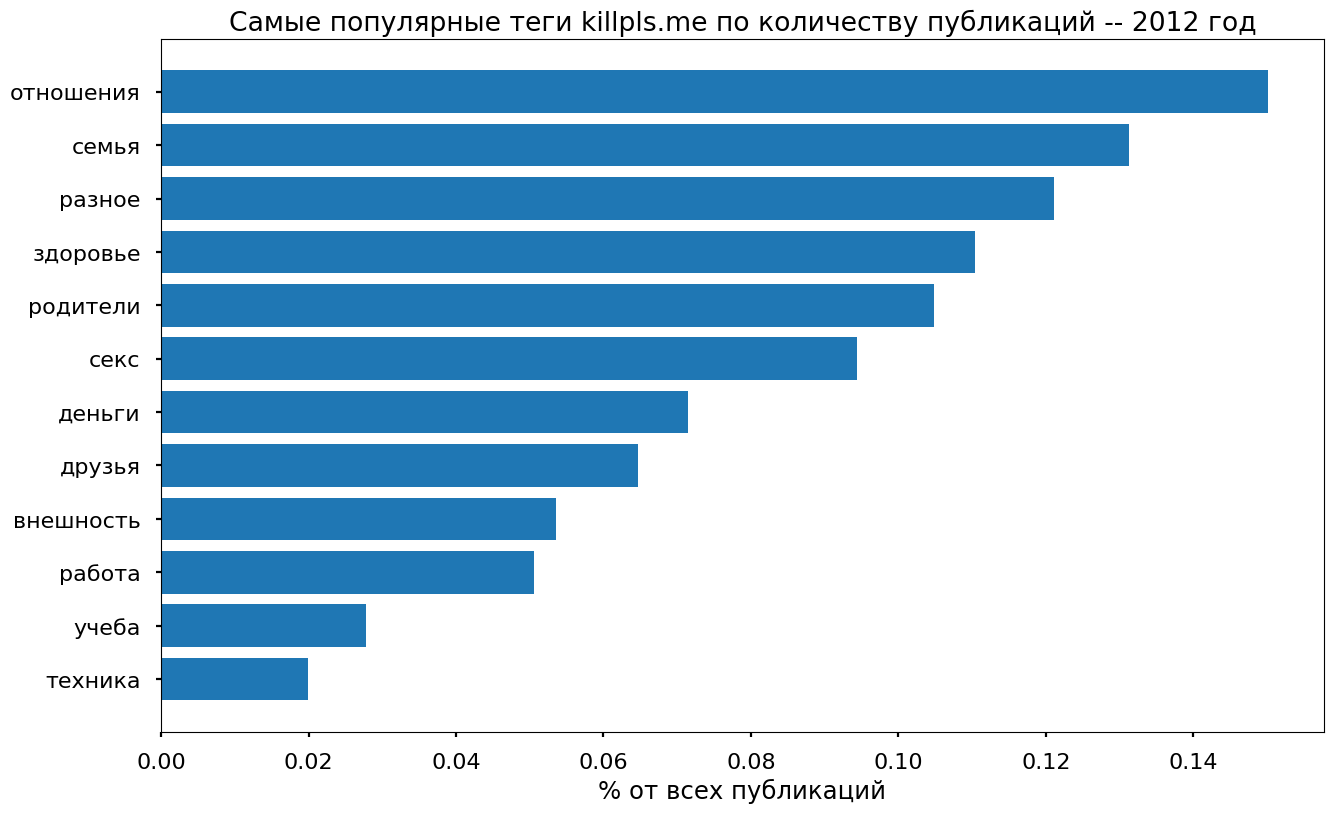

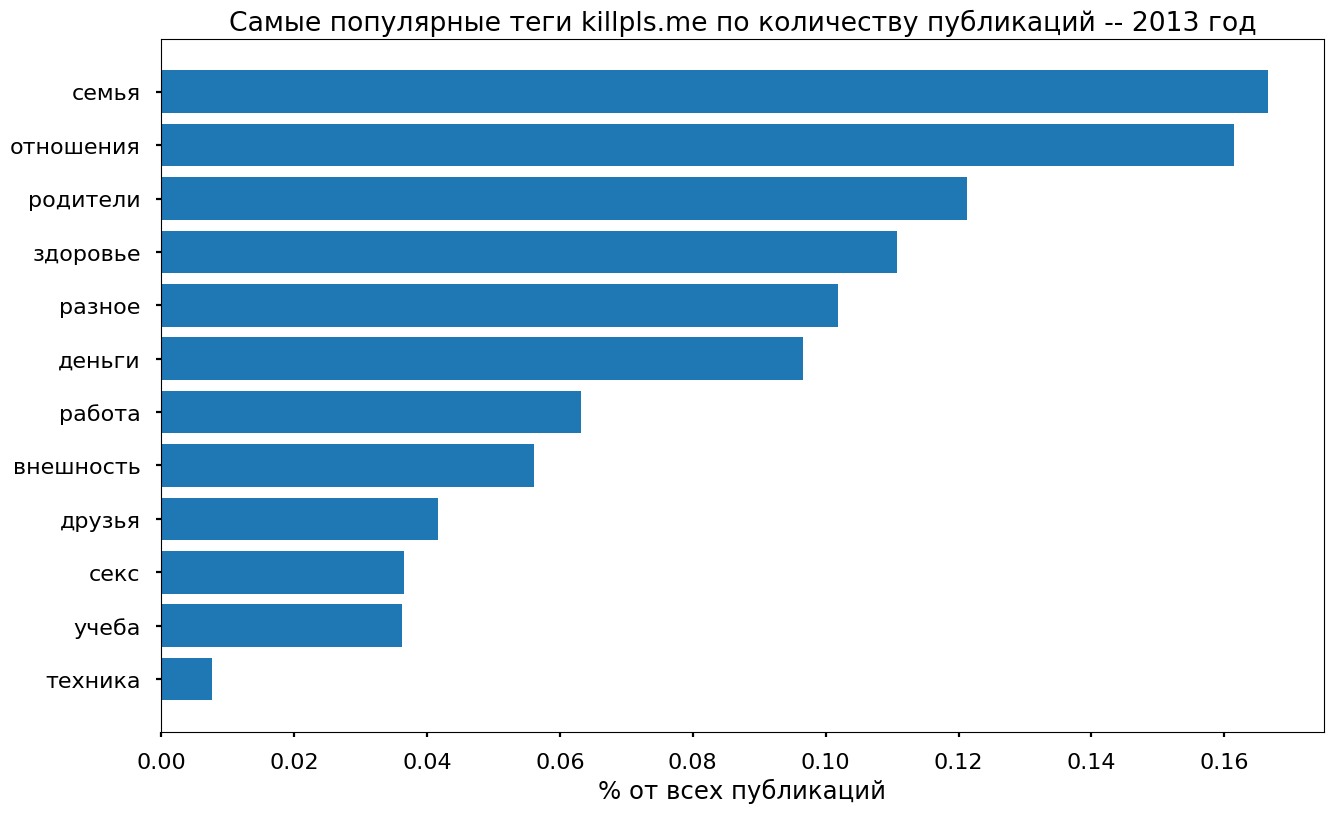

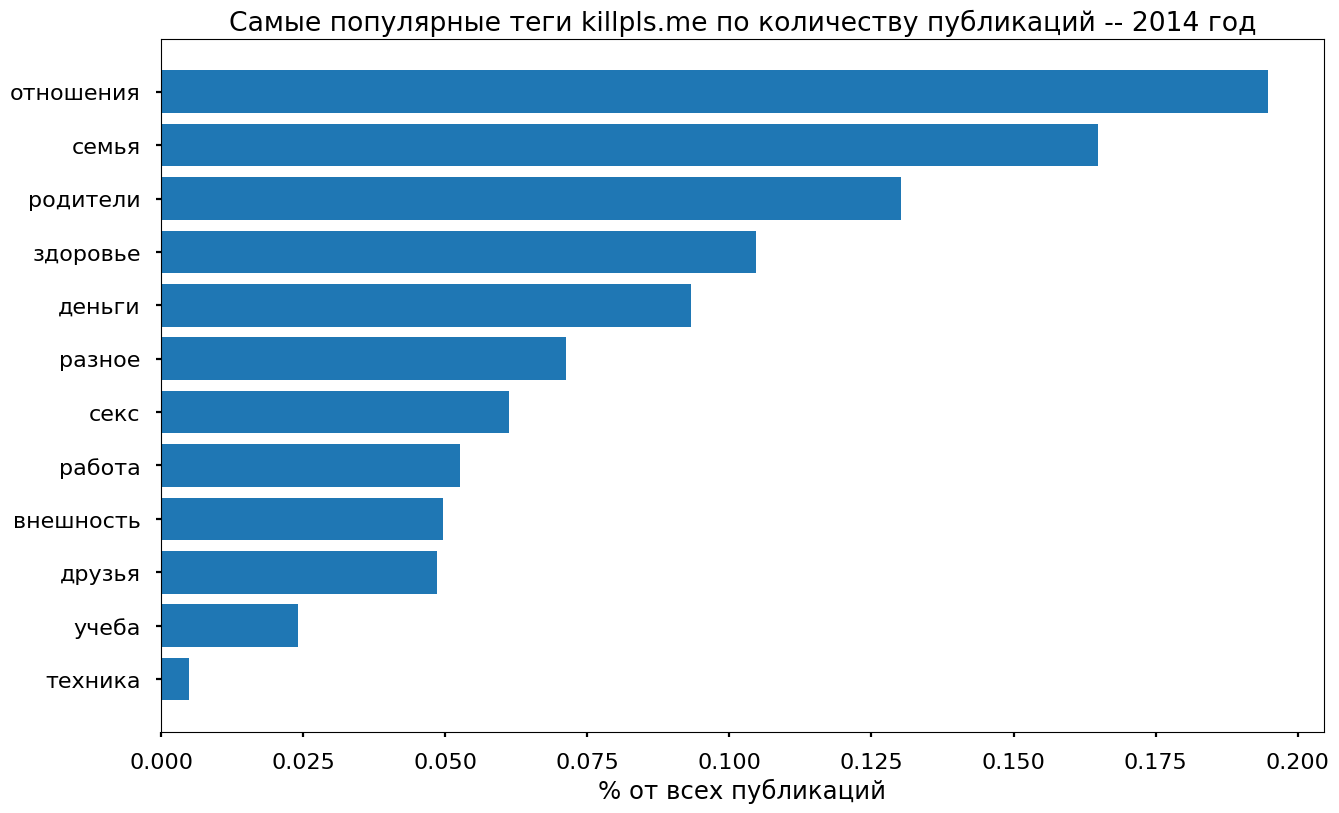

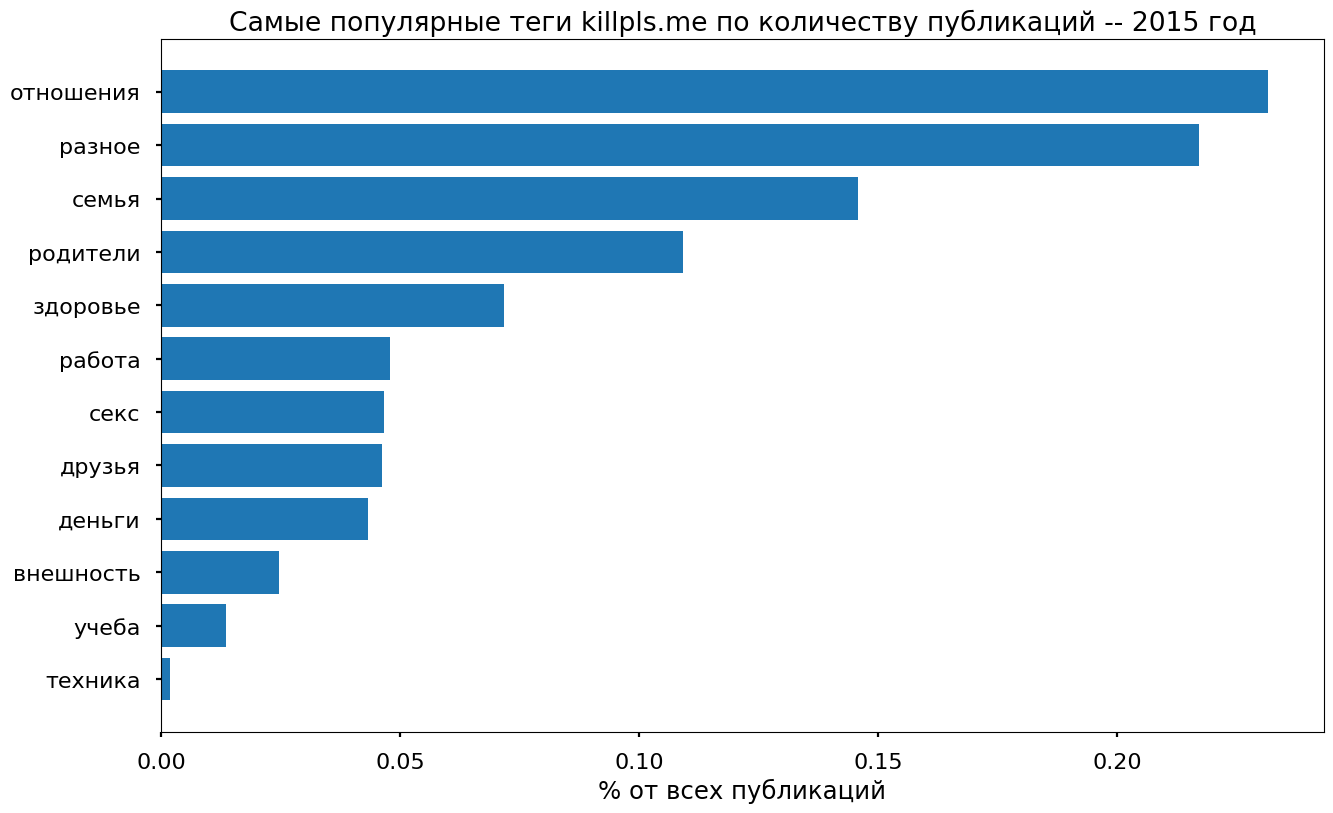

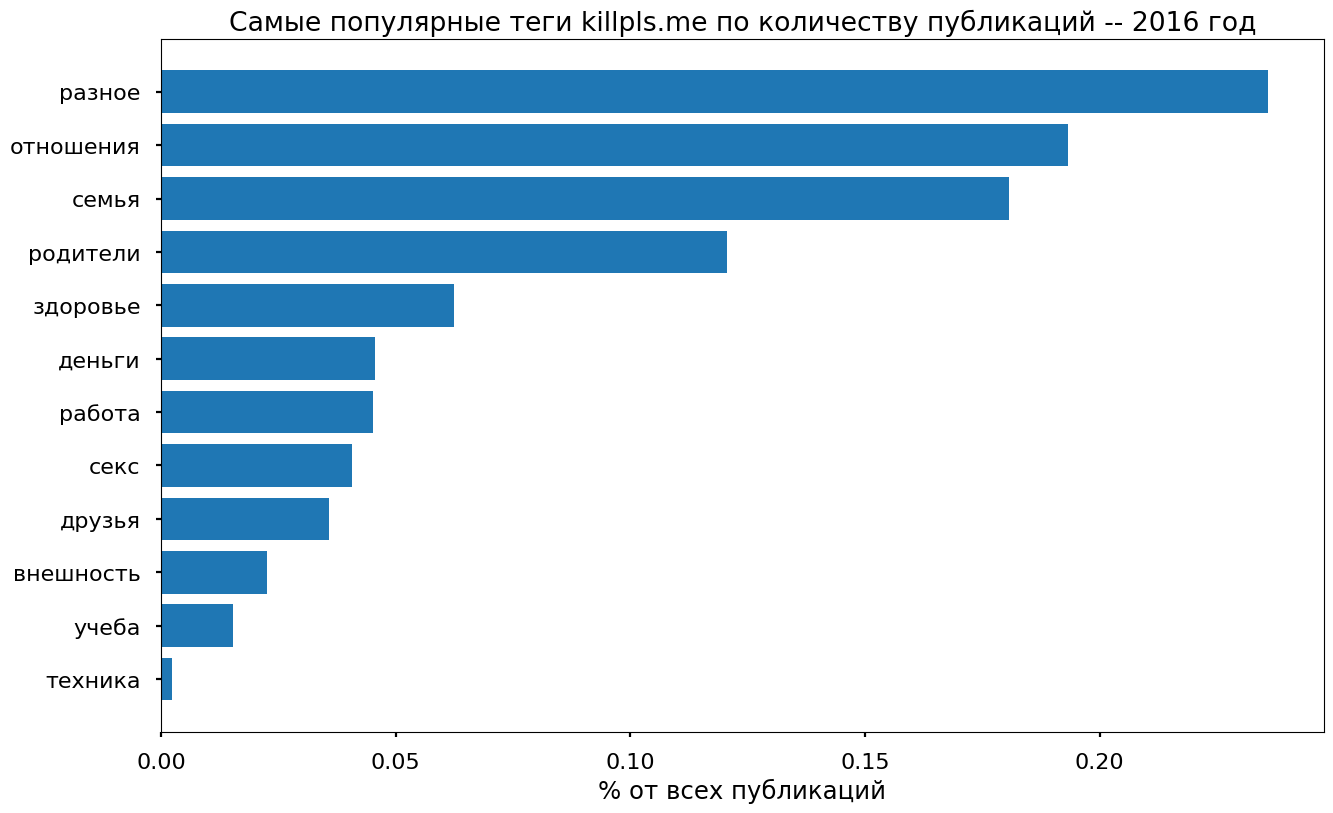

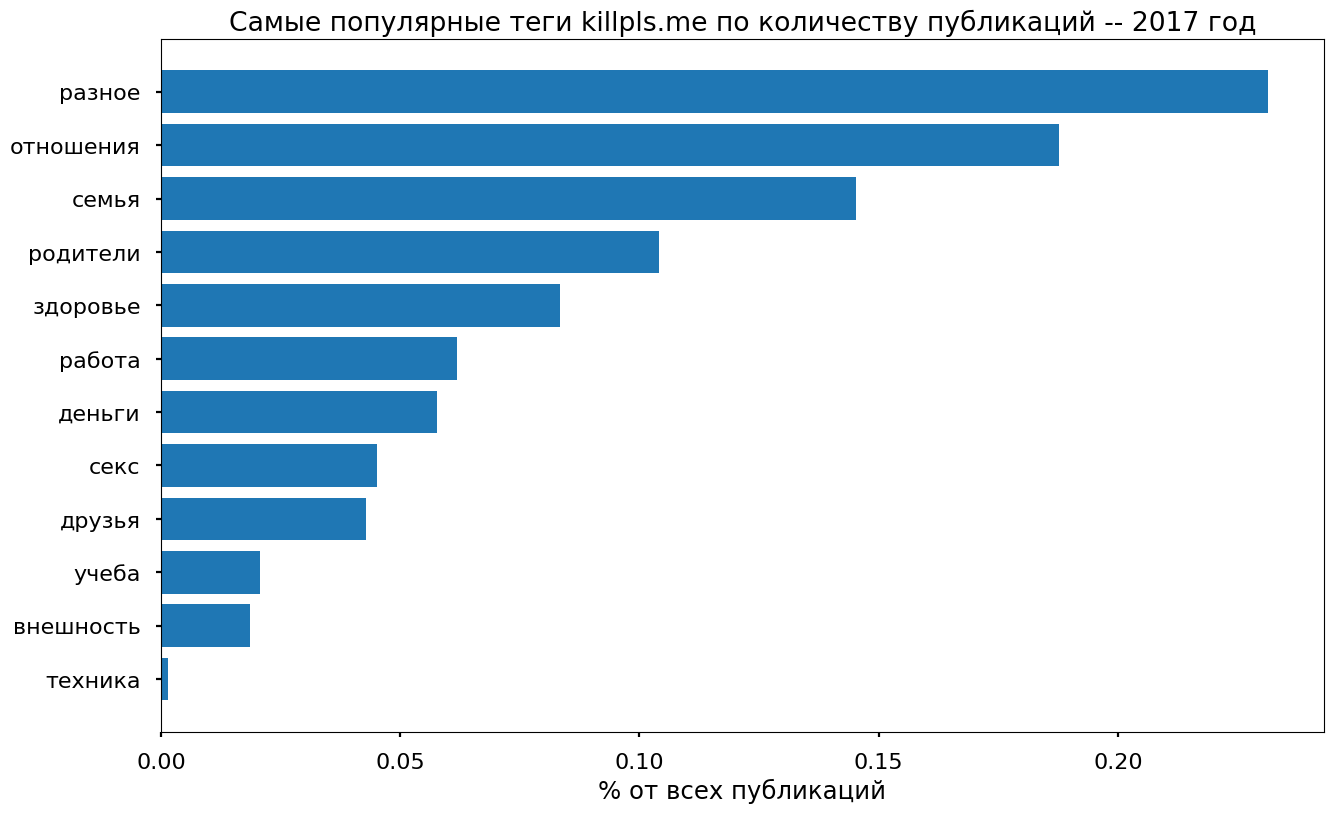

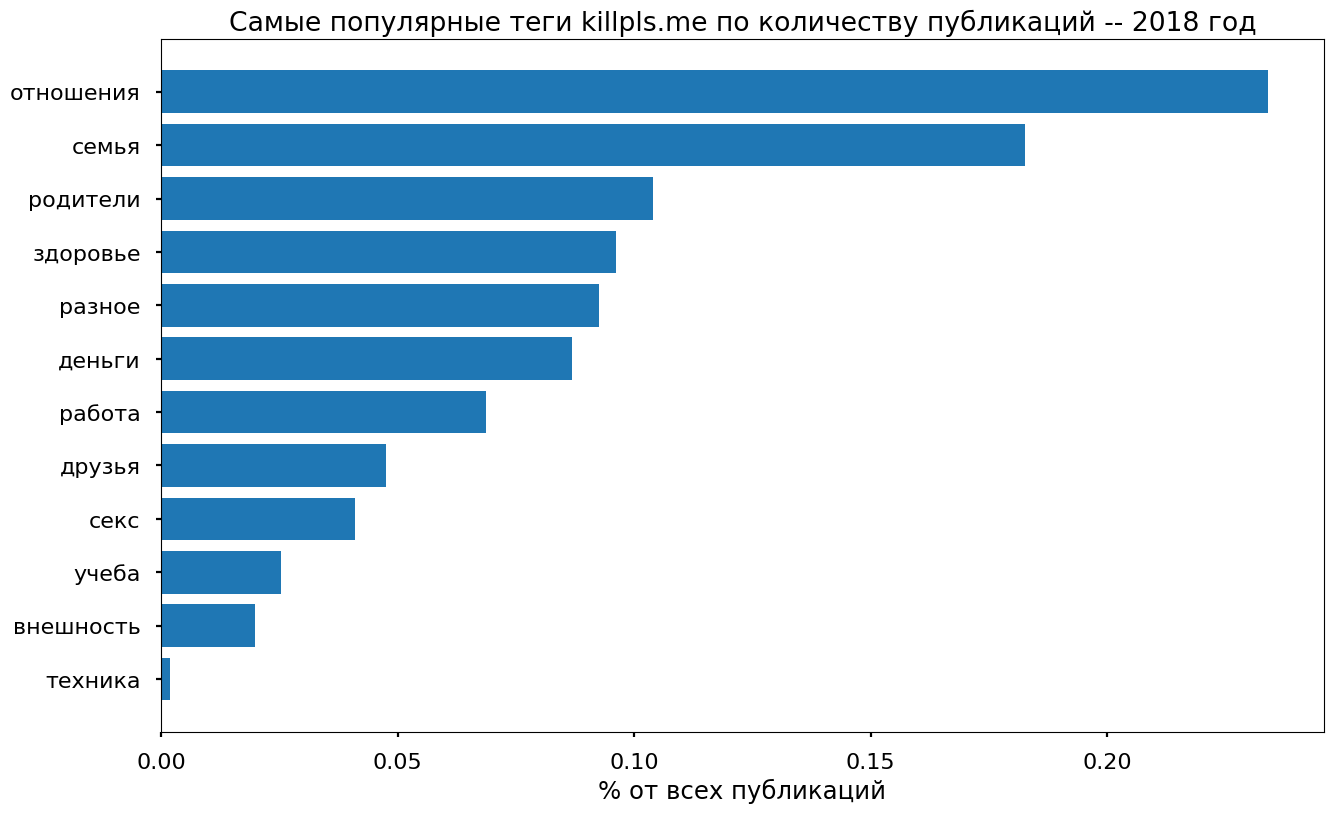

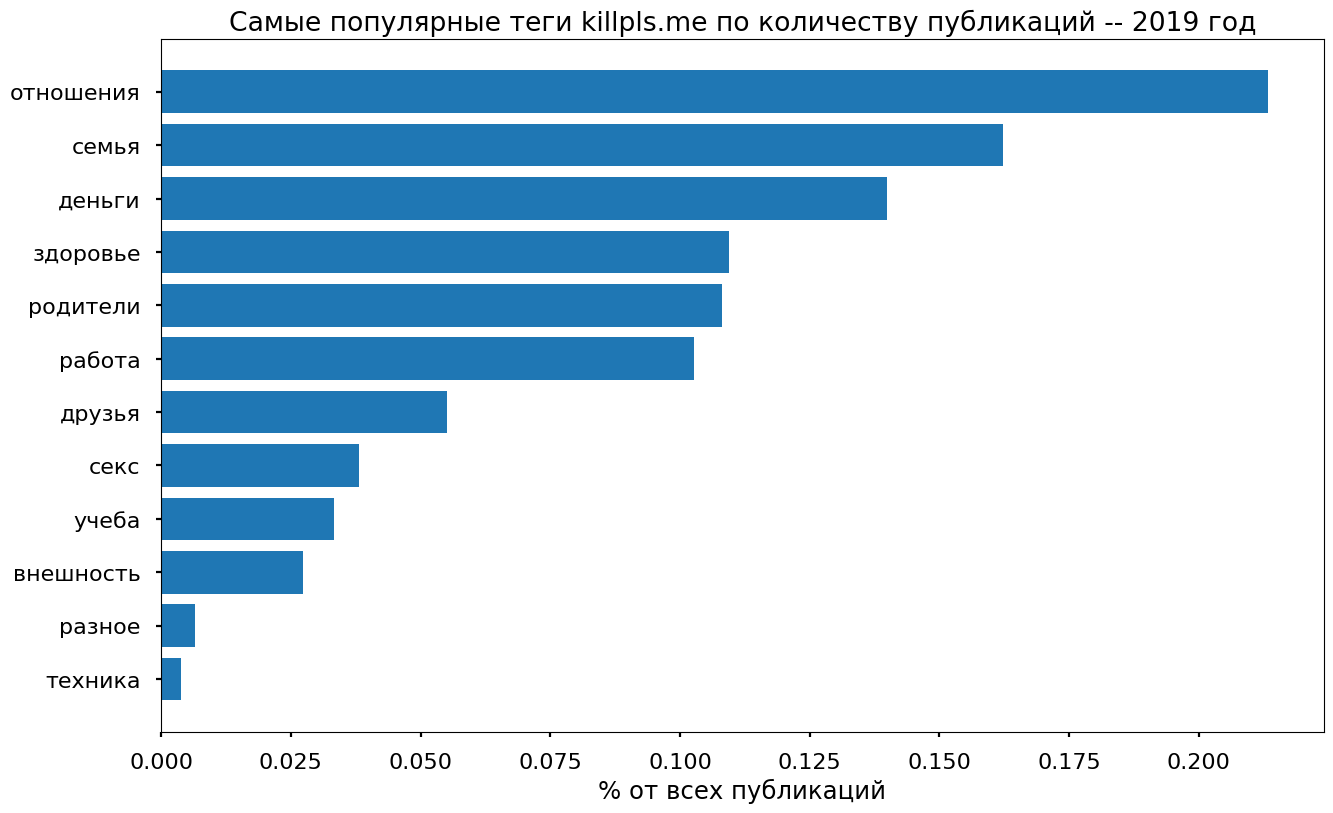

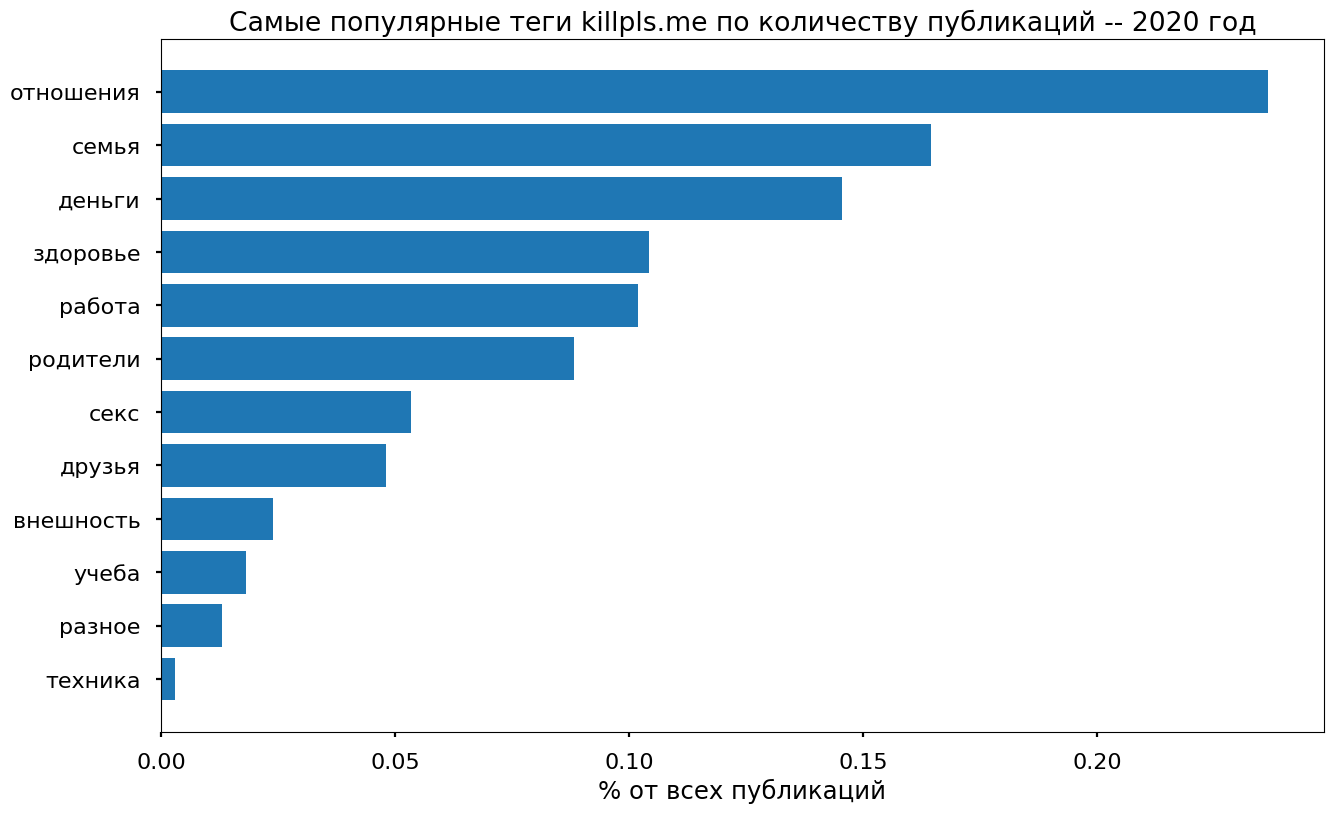

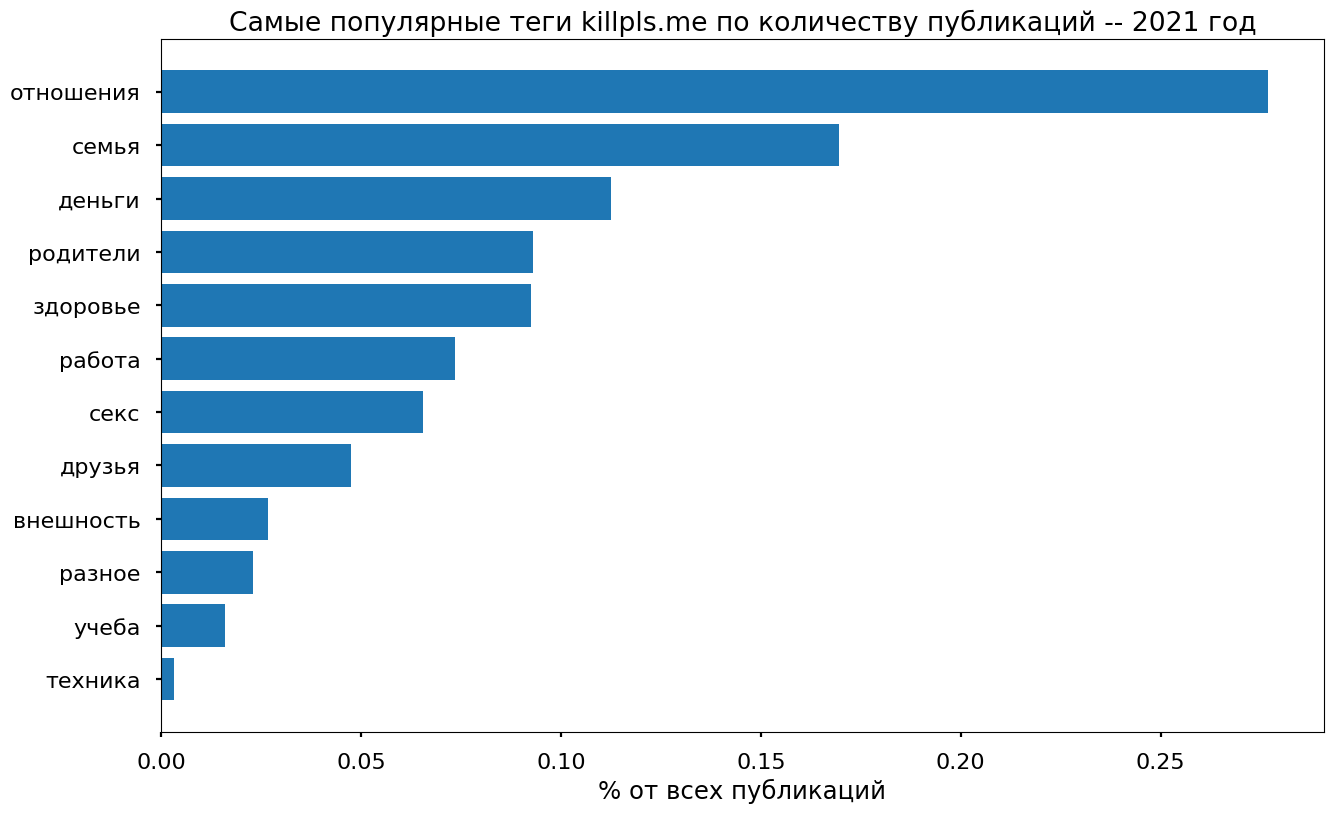

In [35]:
for year in df_tags_count_years.years.unique():
    plot_bar(
        title='Самые популярные теги killpls.me по количеству публикаций -- {} год'.format(year), 
        xlabel='% от всех публикаций', 
        x=df_tags_count_years[df_tags_count_years.years == year].sort_values('rate').tags, 
        y=df_tags_count_years[df_tags_count_years.years == year].sort_values('rate').rate
    )

In [36]:
df_count_years = df.groupby(['years'])['tags'].value_counts().reset_index(0)
df_count_years.columns = ['years', 'count']
df_count_years = df_count_years.reset_index()
df_count_years = df_count_years[df_count_years['tags'].isin(['секс','внешность','здоровье','деньги'])]
df_count_years = df_count_years.pivot(index="years", columns=["tags"],values="count")
df_count_years = df_count_years.divide(df_count_years.sum(axis=1), axis=0)

In [37]:
df_count_years

tags,внешность,деньги,здоровье,секс
years,,,,
2009,0.115385,0.301538,0.227692,0.355385
2010,0.121090,0.234107,0.268416,0.376387
2011,0.160976,0.225366,0.282927,0.330732
2012,0.162376,0.216832,0.334653,0.286139
2013,0.187117,0.322086,0.369121,0.121677
2014,0.160535,0.302118,0.338907,0.198439
2015,0.132759,0.232759,0.384483,0.250000
2016,0.131624,0.266667,0.364103,0.237607
2017,0.090305,0.281541,0.407703,0.220452


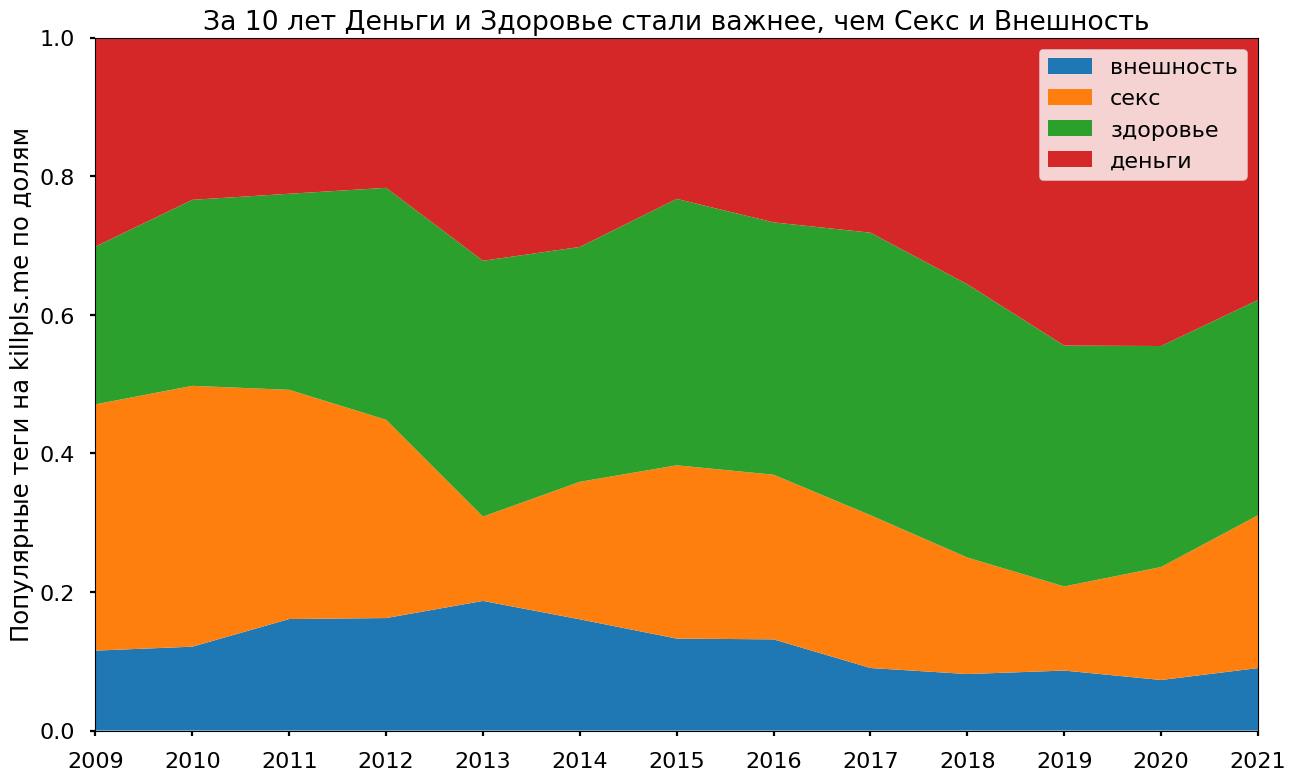

In [40]:
plt.figure(figsize=[15, 9])
plt.title('За 10 лет Деньги и Здоровье стали важнее, чем Секс и Внешность')
plt.stackplot(df_count_years.T.columns, 
              df_count_years[['внешность', 'секс', 'здоровье', 'деньги',]].T, 
              labels=df_count_years[['внешность', 'секс', 'здоровье', 'деньги',]].T.index)
plt.margins(0,0)
plt.ylabel('Популярные теги на killpls.me по долям')
plt.legend()
plt.show()

## Text Analisis

In [41]:
# Load USE model for text vectorization
embed_model = tf.saved_model.load(USE_MODEL)

In [42]:
df_text.shape

(27351, 3)

In [43]:
# Delete row that contained only '18+'
df_text = df_text[df_text['clean_text'] != '18+']

In [44]:
df_text.shape

(24595, 3)

In [45]:
# Generate embeddings
embds = USEEncoder(config['USEEncoder']).transform(df_text, embed_model)

100%|██████████| 384/384 [03:57<00:00,  1.62it/s]


In [46]:
embds.shape

(24595, 512)

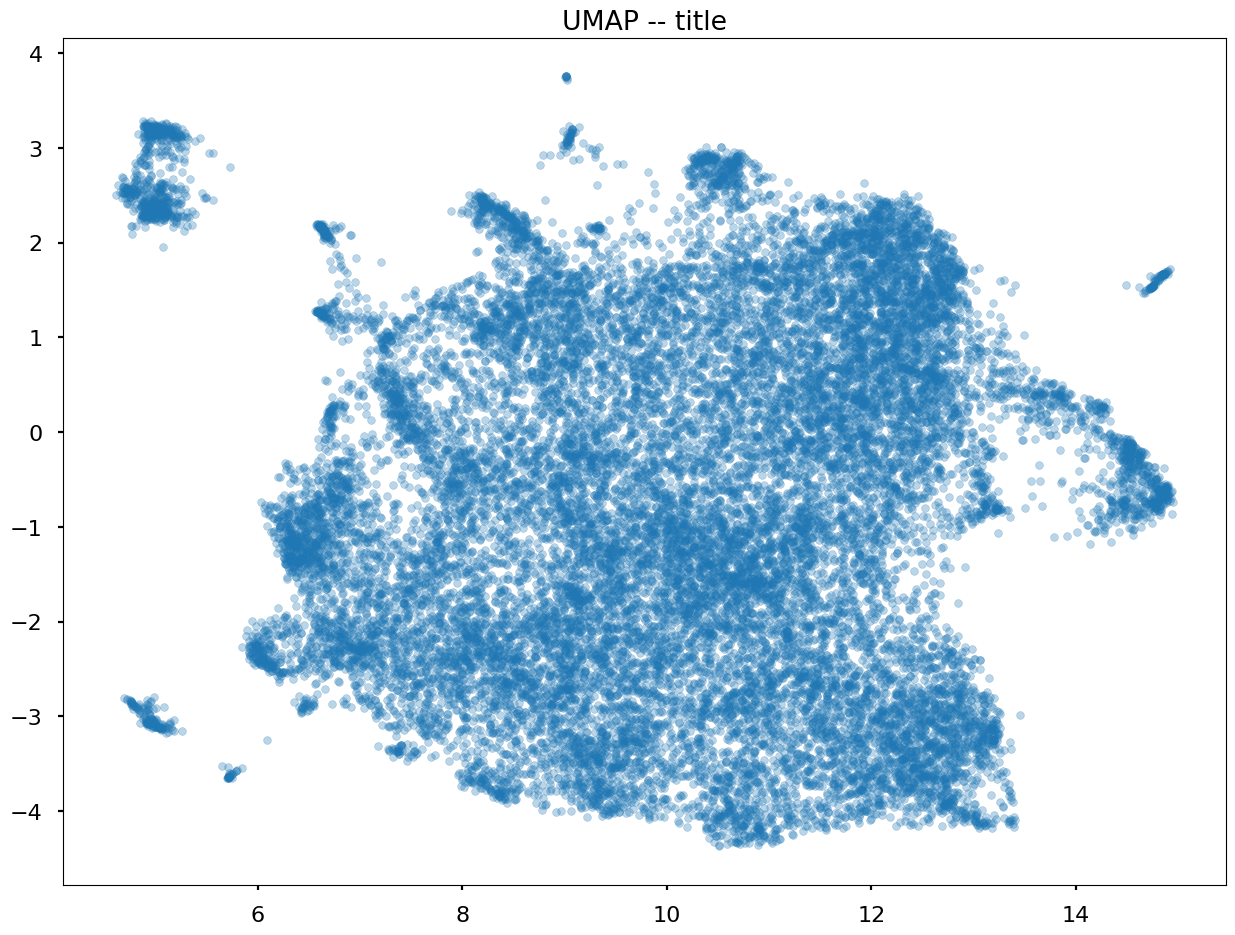

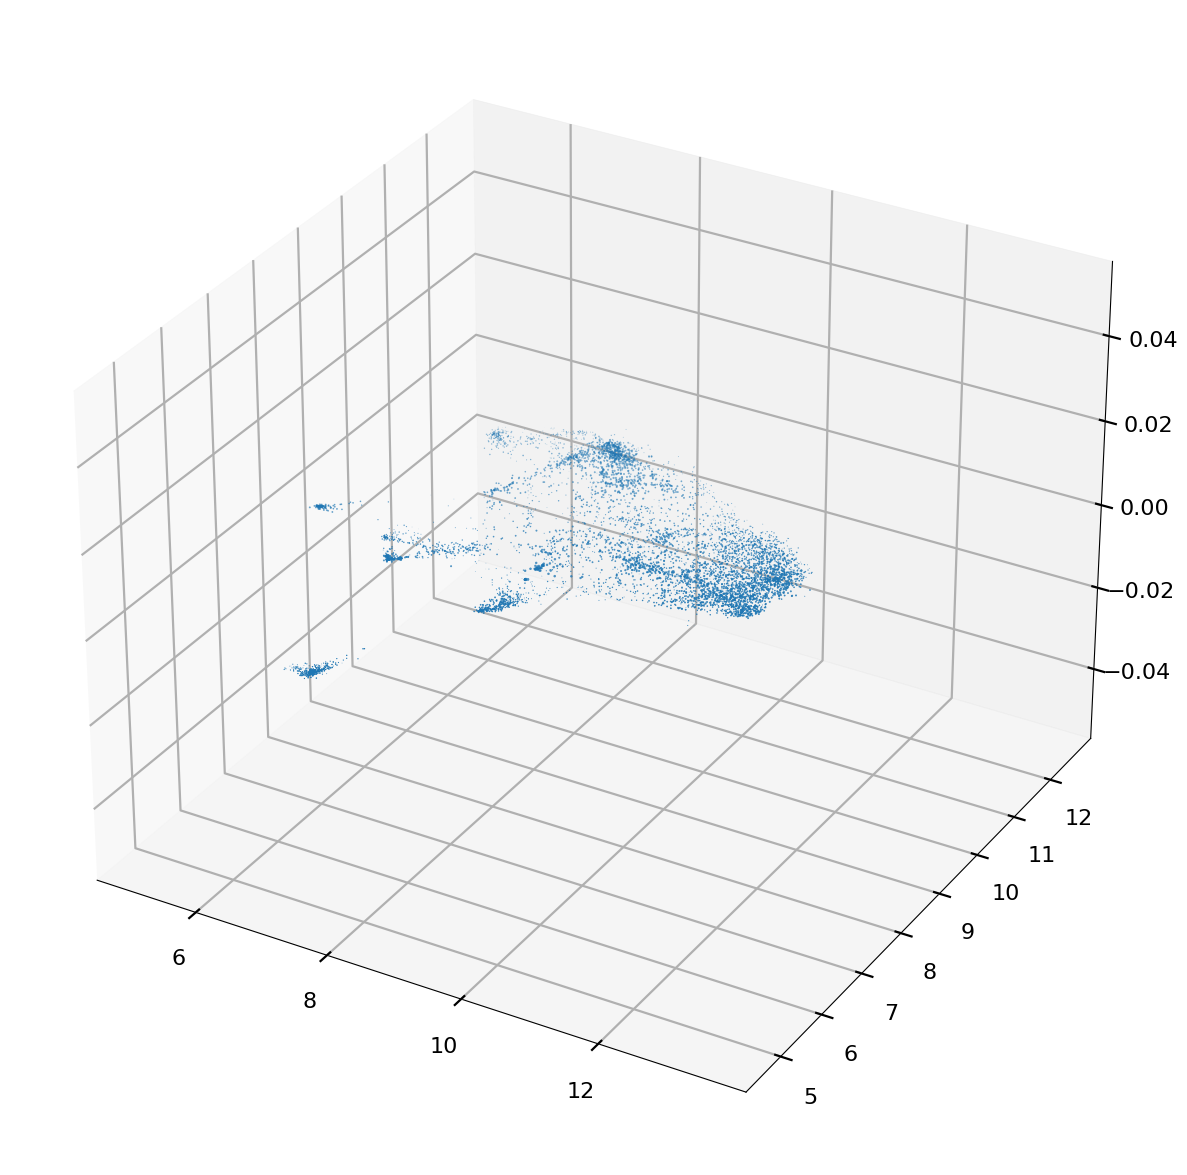

CPU times: user 1min 47s, sys: 10.6 s, total: 1min 57s
Wall time: 54.7 s


In [47]:
%%time
process_umap(embds, 'title', alpha=.3)

100%|██████████| 19/19 [21:15<00:00, 67.13s/it] 


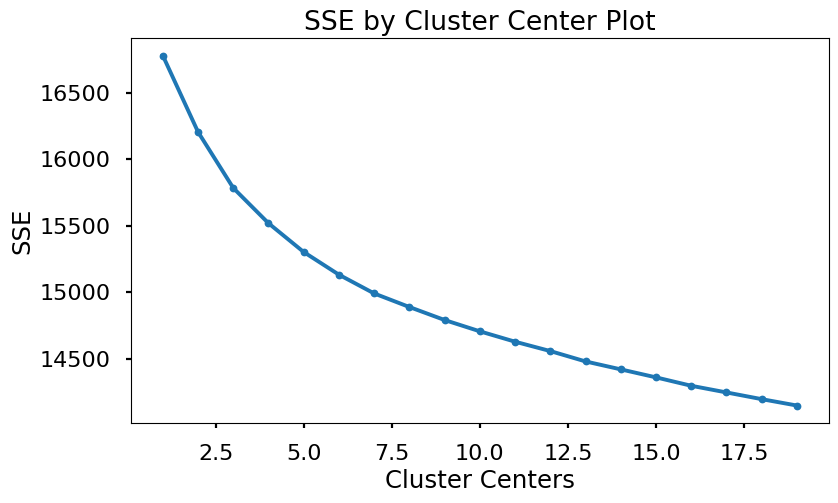

In [48]:
# Calculate optimal number of clusters
calculate_number_clusters(data=embds, max_k=20, max_iter=100, n_init=5)

In [48]:
%%time
kmeans = KMeans(n_clusters=7, max_iter=100, n_init=5, random_state=SEED).fit(embds)

CPU times: user 1min 38s, sys: 21.8 s, total: 2min
Wall time: 30.8 s


In [49]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([4766, 3435, 4427, 2603, 2947, 3893, 2524]))

In [50]:
# Add number of clusts into data
df_text['clusts'] = kmeans.labels_

In [52]:
# The most popular tags in clusters
df_clusts = pd.DataFrame(df_text.groupby('clusts')['tags'].value_counts())
df_clusts.columns = ['counts']
df_clusts = df_clusts.reset_index()
for i in range(len(np.unique(kmeans.labels_))):
    print(df_clusts[df_clusts['clusts'] == i].head(2),'\n')

   clusts        tags  counts
0       0  отношения     2064
1       0     разное      439 

     clusts             tags  counts
382       1  семья , деньги      326
383       1       отношения      283 

     clusts        tags  counts
673       2     разное     1454
674       2  отношения      353 

      clusts              tags  counts
1373       3           работа      555
1374       3  работа , деньги      270 

      clusts       tags  counts
1673       4  здоровье      488
1674       4    разное      352 

      clusts       tags  counts
1984       5     семья      684
1985       5  родители      670 

      clusts        tags  counts
2286       6      семья      365
2287       6  отношения      335 



In [53]:
# Union some clusters
df_text.loc[(df_text['clusts'] == 5) | (df_text['clusts'] == 6), 'clusts'] = 1

In [54]:
df_text['clusts'].value_counts()

1    9852
0    4766
2    4427
4    2947
3    2603
Name: clusts, dtype: int64

In [40]:
# Отношения
TextSummarizer({'len_summary': 50, 'text_column': 'text'}).transform(df_text[df_text['clusts'] == 0])

100%|██████████| 28719/28719 [01:04<00:00, 444.45it/s]


'До этого жили вместе 5 лет, а знаем друг друга всю жизнь. И все это время у него есть девушка, они вместе уже 7 лет. Мужу боюсь сказать, это его лучший друг с 12 лет. Полгода встречаемся, до этого лет пять были просто друзьями. Встречаемся с парнем три года, живем вместе, все чудесно. Мне кажется это он все подстроил.\rПарня Дима зовут, 20 лет. Год встречался с девушкой, любил ее, какое-то время жили вместе. И это после 2 лет совместной жизни.\rКМП ап стену... \tГод назад было все хорошо,любимый человек,лучший друг. \rА в этом году все стали говорить, что он ходит вокруг меня. А потом узнала, что он живет с девушкой уже несколько лет...\rКМП. Очень люблю свою девушку, встречаемся уже три года, душа в душу.  И при этом я хотела бы всю жизнь провести с ним вместе...\rКМП. \rВстречалась с парнем три года, все шикарно, просто мой идеал. \rСейчас мне 27, мы все с тем же парнем, живем вместе уже пять лет. Встречаемся год, месяц живем вместе, все отлично. Встречаюсь с парнем 2 года, последни

In [41]:
# Семья
TextSummarizer({'len_summary': 50, 'text_column': 'text'}).transform(df_text[df_text['clusts'] == 1])

100%|██████████| 67899/67899 [02:56<00:00, 384.36it/s]


'КМП, сын - это все для нас, мы с мужем этого просто не переживем. Я очень хочу детей, с мужем пытались больше 5 лет и всё никак. Мы в разводе больше года, но она все еще не может принять это.  Его мама много лет живет одна, это могло случиться в любой момент. Прожила с мужем 20 лет, все это время будучи домохозяйкой. Видимо, от святого духа, и когда мама скажет.\rКМП, надоело это все. КМП, это мой первый год взрослой и независимой жизни, а уже устала. Я давно хочу детей, муж об этом знал еще до свадьбы. Жили с мужем вместе пять лет, детей планировали в скором времени. Они с мужем мечтали об этом ребенке 10 лет. Очень жаль 10 лет дружбы, она и муж - самые близкие мне люди, КМП. Живем в одном доме все вместе: муж, сын, мои мама и папа. И как сын мог все это запомнить в 2 года. И могли бы сказать - пройдет, это гормоны, но ребенку уже год.  КМП, я просто не могу понять, за что мне это и как жить дальше. Все это при ребенке 4.5 лет. КМП, мне еще год в школе, не знаю, как с ними жить. Но п

In [42]:
# Разное
TextSummarizer({'len_summary': 50, 'text_column': 'text'}).transform(df_text[df_text['clusts'] == 2])

100%|██████████| 20021/20021 [00:39<00:00, 501.57it/s]


'".\rИ это все из-за людей, которых я больше всего любила.\r ПМП. КМП, я потратила на дрессировку этого пса два года и кучу денег. \rА я виновата только в том, что ребёнок все это видел.\rПМП. \rПМП, а то я уже три месяца мучаюсь, не могу этого сказать. "Это просто не день Бекхема..." ПМП . \rКМП, не хочется идти в школу и смотреть в глаза этим людям. В общем, я устала от этого, хочу нормально жить, ПМП. И времени ходить по всем этим инстанциям тоже особо нет.\rКМП. мы просто забыли тебе об этом сказать.\r ПМП. А теперь КМП, это моя бабушка, ей 62 года. Я не могла понять,ЗАЧЕМ он это сделал.\rА вот теперь ПМП. КМП, это уже продолжается 10 лет, с самого детства. Новый Год..пять дней пьянки - три дня прогула на работе...ПМП . Я за него замуж собиралась, блин.\rКМП, а еще лучше дурака этого. \rОтдать собаку в хорошие руки муж не смог - псу уже 9 лет.\rКМП. И это в 13 лет.\rКМП . Не знаю, что с этим делать, КМП. Я не понимаю, зачем я всё это делаю, ПМП. \rЯ его так сильно люблю, страшно об

In [43]:
# Работа
TextSummarizer({'len_summary': 50, 'text_column': 'text'}).transform(df_text[df_text['clusts'] == 3])

100%|██████████| 15713/15713 [00:25<00:00, 619.38it/s]


'3 года работы.\rЭто все за 4 месяца.\rКМП. Работаю с 17 лет, и всю жизнь с работой не везёт. Год назад я жил с родителями и работал на высокооплачиваемой работе. КМП - не могу поверить, что пять лет потратила на ЭТО. Все это время пыталась найти более серьезную работу - везде отказ. 2020 год, апрель, осталась без работы, денег, все как всегда. При всем при этом - мне только 20 лет.КМП - или я сама. Не мог найти нормальную работу, из-за этого ушла жена, забрав детей. А в это время и на работе все пошло \rпрахом, уволилась со скандалом. Я так любила свою работу и наш отдел, все работало как часы. Это занимает все ее время,естественно, пришлось оставить работу. Это буквально работа, о которой я мечтал всю жизнь, но... Это еще работы почти на полгода, если все будет хорошо. Понимаю что это всего лишь просто работа, но не выдерживаю уже. Ни работы, ни дома, не парня, ни денег...\rКМП . 1 год работы насмарку + из-за этого она ставит мне 3 по ее предмету. Сижу на работе, но никак не могу най

In [55]:
# Здоровье
TextSummarizer({'len_summary': 50, 'text_column': 'text'}).transform(df_text[df_text['clusts'] == 4])

100%|██████████| 18445/18445 [00:33<00:00, 555.56it/s]


'КМП, из-за всего этого отношения с каждым годом все хуже. ПМП, это продолжается уже третий год, я так просто не могу. а ведь ей всего 42..\rКМП, так устала на все это смотреть и бояться. Я живу в обществе дебилов и ничего не могу с этим сделать, КМП.. скоро Новый Год, а все, что я хочу - это вылечиться. Просто КМП, не могу понять, что это было. Она до сих пор меня в этом корит.\rКМП, больше так не могу. Все это время не могу спокойно жить. Мне 20 лет, я этим летом мы планировали свадьбу.\rКМП. КМП, ведь в этом году ему 329, а мне 20. Все понимаю, но это чувство больше меня...\rПМП наивного дурака.\r. Было это все полтора года назад. Это же мог делать и мой младший брат на 2 года младший меня. За несколько лет оправилась и от этого, хотя долго не хотела жить. КМП, я просто хочу жить как все.  Хотя могу не пить вообще 2-3 недели подряд.Не хочу так жить, КМП . \rВместе 5 лет, все это проявлялось постепенно. \rПМП, я не могу это больше держать в себе.\r. И это все произошло за два года. Б

+ Лучшие годы сайта пришлись 2010-2011 гг. Активность имеет сезонность: пики публикаций приходятся на май и конец августа, резкий спад - январь, февраль.


+ Самые популярные теги по количеству публикаций и теги, которые вызвали наибольшее сочувствие, не совпадают. Почему? Кризисы? Субъективное восприятие?


+ Отношения есть у всех, но не всем нравится читать об одном и том же. А вот проблемы со здоровьем и в семье должны быть понятны всем. Но по сочувствию лидируют почему-то секс и внешность.


+ Наибольшая активность аудитории пришлась на 2010-2011 гг.. Потом количество историй стало сокращаться медленно, а вот вовлечённость просела сильно. Подростки лайкали гораздо активнее и продвинули те темы, которые их наиболее волнуют. 


+ Аудитория сайта повзрослела: 2009 - внешность и секс, 2010 - внешность и секс, 2011 - секс и родители, 2012 - секс и учёба, 2013 - секс, 2014 - здоровье, родители, секс, 2015 - внешность и семья, 2016 - семья, родители, деньги, внешность, 2017 - семья, родители, разное, деньги, 2018 - техника, родители, семья, здоровье, 2019 - техника, семья, здоровье, родители, 2020 - родители, техника, семья, здоровье.


+ С 2018 г. у аудитории начались взорослые проблемы.


+ Проблем с сексом в семейной жизни нет, как и самого секса.


+ Техника - это серьёзные проблемы с деньгами (кредитные айфоны, разбитые машины, сломанные бытовые приборы первой необходимости и невозможность купить новые).


+ Из-за наличия мощных трендов сложно понять локальные (здоровье, деньги, техника). В 2014 г. наступил переломный момент секс окончательно вышел из топа (юмап)


+ Сезонность по месяцам: весной с отношениями больше всего проблем, чем ближе к концу года, тем проблем в деньгами больше, проблем со здоровьем больше в зимние месяцы.


+ Наибольшее кол-во жалоб в пятницу. Наименьшее - выходные. Хотя разница не столь велика.


+ К концу месяца динамика снижается, но неоднозначно.